In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from matplotlib.font_manager import fontManager, FontProperties
import ptitprince as pt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
import pingouin as pg
import statsmodels.api as sm
import language_tool_python as ltp
from PIL import Image


def get_img(name):
    path = "font/emojis/{}.png".format(name)

    if name == 'Human':
        img = plt.imread(path)
    else:
        img = np.asarray(Image.open(path).resize((136, 128)))

    #  im = plt.imread(img)

    return img

def offset_image(coord, name, ax, size=0.5):
    img = get_img(name)
    im = OffsetImage(img, zoom=size)
    im.image.axes = ax
    ab = AnnotationBbox(im, (coord, 0),  xybox=(0., -21.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)
    ax.add_artist(ab)

def raincloud(x, y, markersize, df, order=None, hue=None):
    # adding color
    pal = sns.color_palette()
    if df is not None:
        means = df.groupby([x], as_index=True)[y].mean().reindex(order)
    else:
        if len(order) > 2:
            raise Exception('Too many unique x values for this custom plot')

        mean_1 = np.mean([i[0] for i in zip(y, x) if i[1] == order[0]])
        mean_2 = np.mean([i[0] for i in zip(y, x) if i[1] == order[1]])
        means = [mean_1, mean_2]

    dodge = None
    if hue:
        means = df.groupby([x, hue])[y].mean().reindex(order)
        dodge = True
    print(means.index)
    sns.scatterplot(
        x=means.index,
        y=means,
        color='white',
        edgecolor='black',
        s=150/2, linewidth=1.5, zorder=4)

    ax = pt.half_violinplot(x=x, y=y, data=df, palette=pal, bw=.25, cut=0., linewidth=0,
                            scale="area", width=.7, inner=None, orient='v', zorder=1, order=order, hue=hue, dodge=dodge)
    ax = sns.stripplot(x=x, y=y, data=df, palette=pal, edgecolor="white",  linewidth=1, order=order,
                       size=markersize, orient='v', zorder=2, jitter=1, alpha=0.6, hue=hue, dodge=dodge)

    ax2 = sns.pointplot(x=x, y=y, data=df, color='black',  join=False, errorbar='se', linewidth=1,
     edgecolor='black', capsize=.06, zorder=3, bw=0, order=order, hue=hue, dodge=dodge)

In [3]:
f1 = 'HUMANS/turing_dv3_82.csv'
f2 = 'HUMANS/turing_109.csv'
f3 = 'HUMANS/turing_prolific_79.csv'
f4 = 'HUMANS/turing_dv2_humanized_79.csv'
f5 = 'HUMANS/turing_dv2_ai_74.csv'

df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)
df3 = pd.read_csv(f3)
df4 = pd.read_csv(f4)
df5 = pd.read_csv(f5)

for df, n_rows, engine in zip([df1, df2, df3, df4, df5], [135, 138, 138, 138, 147], ['dv3', 'dv2', 'dv2_prolific', 'dv2_humanized', 'dv2_ai']):
    df = df[df.prolific_id.isin(df.prolific_id.value_counts()[
                                df.prolific_id.value_counts() == n_rows].index)]
    # df = df[~df.prolific_id.str.contains('anon')] 
    # df = df[~df.prolific_id.str.contains('notfound')]

    print("complete =", (df.groupby('prolific_id').prolific_id.count() == n_rows).sum())
    print("incomplete =", (df.groupby(
        'prolific_id').prolific_id.count() != n_rows).sum())
    # print("dataset_id that are complete =", df.dataset_id.value_counts()==138)
    print("dataset_id that are incomplete =",
          [
              i for i in range(77)
              if i not in df.dataset_id.value_counts().index
          ])
    print("dataset_id that are complete =",
          [
              i for i in range(77)
              if i in df.dataset_id.value_counts().index
          ])

    print("dataset_id that are incomplete =",
          len(
              [i for i in range(77) if i not in df.dataset_id.value_counts().index]))

    df.loc[:, 'correct'] = None
    df.loc[:, 'correct'] = df.correct.astype(bool)
    df.loc[:, 'agree1'] = None
    df.loc[:, 'agree1'] = df.agree1.astype(bool)
    
    df.loc[:, 'agree2'] = None
    df.loc[:, 'agree2'] = df.agree2.astype(bool)

    print(set(df.answer.unique()))
    
    df.loc[df.q_id == 1, 'agree2'] = df.answer.str.contains('Yes')
    df.loc[df.q_id == 0, 'agree1'] = df.answer.str.contains('Yes')

    # clear weird characters in answers
    df.loc[df.answer.str.contains('Yes'), 'answer'] = 'Yes'
    df.loc[(df.answer.str.contains('No')) & (df.q_id!=2), 'answer'] = 'No'
    df.loc[(df.answer.str.contains('AI')) & (~df.answer.str.contains('Not')), 'answer'] = 'AI'
    df.loc[df.answer.str.contains('Human'), 'answer'] = 'Human'

    print(set(df.answer.unique()))

    df.loc[df.q_id == 2, 'correct'] = df.source == df.answer
    if engine == 'dv2_prolific':
        df.loc[df.q_id == 2, 'correct'] = \
            ((df.source == 'Human') & (df.answer == 'Prolific')) | ((df.source == 'AI') & (df.answer == 'Not Prolific'))
    if engine == 'dv2_ai':
        df.loc[df.q_id == 2, 'correct'] = \
            ((df.source == 'AI_humanized') & (df.answer == 'Not an AI')) | ((df.source == 'AI') & (df.answer == 'AI'))
        df.loc[df.source=='AI_humanized', 'item_id'] = (df[df.source=='AI_humanized'].item_id.astype(str)+"2").astype(int)
        df.loc[df.source=='AI', 'item_id'] = (df[df.source=='AI'].item_id.astype(str)+"1").astype(int)
        # df.loc[df.source=='AI_humanized', 'source'] = 'Human'
        # df.loc[df.answer=='Not an AI', 'answer'] = 'Human'


    # add correct and agree1 to all rows where item id is the same (easier to plot)
    for i in df.item_id.unique():
    #    df.loc[df.item_id == i, 'correct'] = \
        #    df[(df.item_id == i) & (df.q_id == 2)].correct.values[0]
       df.loc[(df.item_id == i) & (df.q_id==2), 'agree1'] = \
            df[(df.item_id == i) & (df.q_id == 0)].agree1.values[0]

       df.loc[(df.item_id == i) & (df.q_id==2), 'agree2'] = \
           df[(df.item_id == i) & (df.q_id == 1)].agree2.values[0]


    ## df['agree1']
    #df['agree_both'] = df.agree1 & df.agree2
    #df['disagree_both'] = ~df.agree1 & ~df.agree2
    df['agree'] = df[['agree1', 'agree2']].mean(axis=1)
    
    # drop where q_id == 0 or 1
    df = df[df.q_id == 2]
    
    df.loc[:, 'engine'] = engine
    
    exec(f'{engine} = df.copy()')

np.random.seed(123)
# TODO: keep only one subject per dataset id
ids_to_keep_dv2 = []
ids_to_keep_dv3 = []
for i in range(77):
    ids_to_keep_dv2.append(
        np.random.choice(dv2[dv2.dataset_id == i].prolific_id.unique()))
    try:
        ids_to_keep_dv3.append(
            np.random.choice(dv3[dv3.dataset_id == i].prolific_id.unique()))
    except:
        print('Index error', i)
dv2 = dv2[dv2.prolific_id.isin(ids_to_keep_dv2)]
dv3 = dv3[dv3.prolific_id.isin(ids_to_keep_dv3)]
# dv2_prolific = dv2_prolific[dv2_prolific.prolific_id.isin(ids_to_keep)]
# ids = dv2.groupby('dataset_id').prolific_id.transform('nunique') > 1
# print(ids)
df = pd.concat([dv2, dv3, dv2_prolific, dv2_humanized, dv2_ai])


complete = 82
incomplete = 0
dataset_id that are incomplete = [76]
dataset_id that are complete = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
dataset_id that are incomplete = 1
{'No', 'AI', 'Human', 'Yes'}


/tmp/ipykernel_19889/3363361657.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = None
/tmp/ipykernel_19889/3363361657.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = df.correct.astype(bool)
/tmp/ipykernel_19889/3363361657.py:39: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

{'No', 'AI', 'Human', 'Yes'}


/tmp/ipykernel_19889/3363361657.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['agree'] = df[['agree1', 'agree2']].mean(axis=1)
/tmp/ipykernel_19889/3363361657.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = None
/tmp/ipykernel_19889/3363361657.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

complete = 112
incomplete = 0
dataset_id that are incomplete = []
dataset_id that are complete = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
dataset_id that are incomplete = 0
{'No', 'Yes', 'Human', 'ðŸ¨â\x8dðŸ¦°Human', 'âœ˜No', 'âœYes', 'ðŸ¤AI', 'AI'}
{'No', 'Human', 'Yes', 'AI'}


/tmp/ipykernel_19889/3363361657.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['agree'] = df[['agree1', 'agree2']].mean(axis=1)
/tmp/ipykernel_19889/3363361657.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = None
/tmp/ipykernel_19889/3363361657.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

complete = 79
incomplete = 0
dataset_id that are incomplete = []
dataset_id that are complete = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
dataset_id that are incomplete = 0
{'No', 'Not Prolific', 'Yes', 'Prolific'}
{'No', 'Not Prolific', 'Yes', 'Prolific'}


/tmp/ipykernel_19889/3363361657.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['agree'] = df[['agree1', 'agree2']].mean(axis=1)
/tmp/ipykernel_19889/3363361657.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = None
/tmp/ipykernel_19889/3363361657.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

complete = 79
incomplete = 0
dataset_id that are incomplete = []
dataset_id that are complete = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
dataset_id that are incomplete = 0
{'No', 'Yes', 'Human', 'ðŸ¨â\x8dðŸ¦°Human', 'âœ˜No', 'âœYes', 'ðŸ¤AI', 'AI'}
{'No', 'Human', 'Yes', 'AI'}


/tmp/ipykernel_19889/3363361657.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['agree'] = df[['agree1', 'agree2']].mean(axis=1)
/tmp/ipykernel_19889/3363361657.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = None
/tmp/ipykernel_19889/3363361657.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

complete = 72
incomplete = 0
dataset_id that are incomplete = [72, 73, 74, 75, 76]
dataset_id that are complete = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
dataset_id that are incomplete = 5
{'No', 'Not an AI', 'Yes', 'AI'}
{'No', 'Not an AI', 'Yes', 'AI'}
Index error 76


/tmp/ipykernel_19889/3363361657.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['agree'] = df[['agree1', 'agree2']].mean(axis=1)


In [26]:
import statsmodels.formula.api as sm

# add length of a1 to df
df['len'] = df.a1.str.len().astype(int)

df['agree1'] = df.agree1.astype(int)
df['agree2'] = df.agree2.astype(int)
# set source AI as 0 and human as 1
df['source2'] = df.source.map({'AI':0, 'Human':1})
df['p_human'] = (df.answer == 'Human').astype(int)

mask_engine = df.engine.isin(['dv2', 'dv3', 'dv2_humanized'])
# df
# probability of agreeing (agree1) predicted by length of the answer
glm1 = sm.logit('p_human ~ len*errors*cond', data=df[mask_engine]).fit().summary()
# sns.lmplot(x='len', y='agree1', data=df, logistic=True, scatter=False)
# plt.ylabel('p(agree)')
# plt.xlabel('length of justification (characters)')
# plt.ylim(.75, .95)

base_filename = 'glm1.txt'
import os
with open(os.path.join('', base_filename),'w') as outfile:
    outfile.write(str(glm1))

Optimization terminated successfully.
         Current function value: 0.621885
         Iterations 6


2342

In [28]:
glm2 = sm.logit('agree ~ len*errors*cond', data=df[mask_engine]).fit().summary()
base_filename = 'glm2.txt'
import os
with open(os.path.join('', base_filename),'w') as outfile:
    outfile.write(str(glm2))

Optimization terminated successfully.
         Current function value: 0.465120
         Iterations 6


2342

In [29]:
glm3 = sm.logit('agree ~ source*answer*cond', data=df[mask_engine]).fit().summary()
base_filename = 'glm3.txt'
import os
with open(os.path.join('', base_filename),'w') as outfile:
    outfile.write(str(glm3))


Optimization terminated successfully.
         Current function value: 0.457138
         Iterations 6


2678

3528


/tmp/ipykernel_2276/1723884661.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df[df.engine=='dv2'].groupby(['prolific_id','source'], as_index=False).mean()


variable=agree1
variable=agree2


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.161816,76,two-sided,0.87188,"[-0.04, 0.03]",0.022816,0.127,0.054489


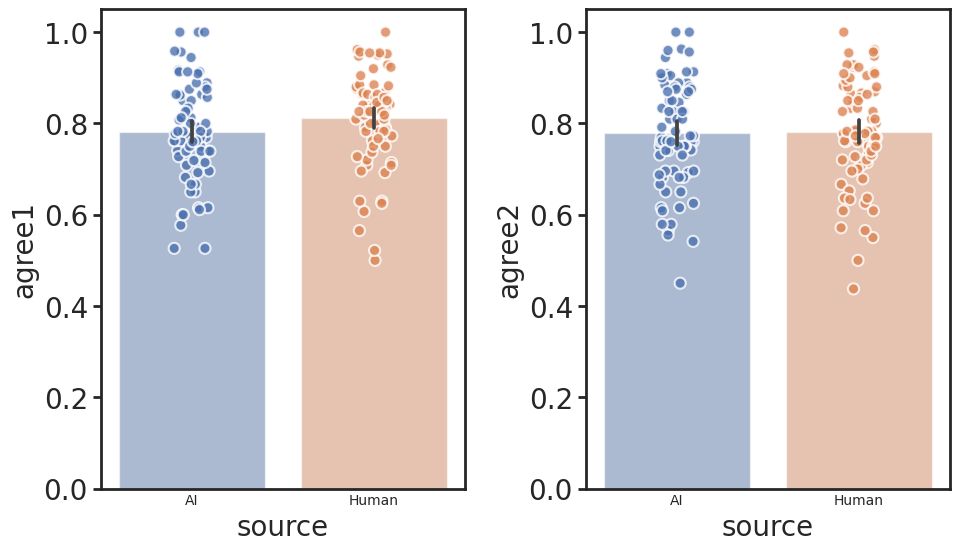

In [136]:
df2 = df[df.engine=='dv2'].groupby(['prolific_id','source'], as_index=False).mean()
sns.set({'figure.figsize':(10, 6), 'font.size': 20})
sns.set_style("ticks")

# change axes width 
plt.rcParams['axes.linewidth'] = 2
# change tick width
plt.rcParams['xtick.major.width'] = 2
# change y tick width
plt.rcParams['ytick.major.width'] = 2

plt.subplot(1, 2, 1)
sns.barplot(x='source', y='agree1', data=df2, alpha=0.5, zorder=0)
sns.stripplot(x='source', y='agree1', data=df2, alpha=0.8, size=8, zorder=1, edgecolor='white', linewidth=1.5)
plt.tick_params(axis='x', length=0)
plt.subplot(1, 2, 2)
sns.barplot(x='source', y='agree2', data=df2, alpha=0.5, zorder=0)
sns.stripplot(x='source', y='agree2', data=df2, alpha=0.8, size=8, zorder=1, edgecolor='white', linewidth=1.5)
plt.tight_layout()
# set xticks length to 0
plt.tick_params(axis='x', length=0)
print('variable=agree1')
pg.ttest(df2[df2.source=='AI'].agree1, df2[df2.source=='Human'].agree1, paired=True)
print('variable=agree2')
pg.ttest(df2[df2.source=='AI'].agree2, df2[df2.source=='Human'].agree2, paired=True)

In [89]:
engine='dv2'
# [i for i in range(0, 3542) if i not in  sorted( df[df.engine==engine].item_id.unique())]
dd = []
for p in df[df.engine==engine].prolific_id.unique():
    dd.append(
        {'prolific_id': p, 'dataset_id': df[(df.engine==engine) & (df.prolific_id==p)].dataset_id.mean()}
    )
dfffff  =pd.DataFrame(dd).sort_values('dataset_id')

df[df.engine==engine].shape


(3542, 22)

In [139]:
N = []
for i, engine in enumerate(('dv2', 'dv3', 'dv2_prolific')):
    N.append(len(df[df.engine == engine].prolific_id.unique()))
    print('Engine=', engine, 'N=', N[i])

n_total = len(df.prolific_id.unique())
# assert n_total == sum(N)

str(question.prolific_id.isin(df[df.engine=='dv2_prolific'].prolific_id.unique()).sum()) + ' ids in dv2_prolific_last_question are in the main dataset'

Engine= dv2 N= 77
Engine= dv3 N= 76
Engine= dv2_prolific N= 79


'69 ids in dv2_prolific_last_question are in the main dataset'

In [8]:
# bonus for correct answers
bonus = df[(df.engine=='dv2_ai') & (df.q_id==2)].groupby('prolific_id').correct.sum() * .05
# bonus = df[(df.engine=='dv2_humanized') & (df.q_id==2) & (df.prolific_id=='61474f07f4cfbc50cb3b2f1e')].drop_duplicates(subset='item_idx', keep="first").correct.sum() * .05
# prolific_ids = ["5edfeb15743509317e9ec17c", "563f5535cbd4c60011dc9466", "60a746a3455cbbaefa083a14", "5c473c74819d580001782651", "60c283d8d82adfb1f4930352", "609bf576ae7704934d02cb52", "5e0fa4276f6d3e6adfca658a", "62d999e7f5f2cde114f4169e", "5edfd8872ec6382f20a1cd90", "5b6362cefaf7d30001e379e7", "5dc04aba55b86247c9991f89", "63bea8c366059643bc8e19da", "59637ac5d6b02c0001439808", "63d3fff8d2afe2d70a9202ba", "62cee0344bbf495f81b5643a", "60da1f2c84d5d4b2e46989c1", "60b6356523a427d506df6952", "5a7e2b4217ef350001704f52", "5b62ebb3c831f00001f60468", "6295f0cc367a8cbba24c694c", "5ef5d78781f1a703a60bf48f", "62fb7e29586929061efccda2", "5d6ed96c3fe1ac001add3be8", "5df227eb99b2821302e8dd5b", "5b438f3f7aec830001bb1a9a", "60d35d4fc34710a66ac98957", "5edd71517bdc7e9b05873eb0", "5d8f382400980b0019e21098", "5a099b6ca383a100011b49ec", "6346921046fa377ce55acbc1", "62cee0344bbf495f81b5643a", "60da1f2c84d5d4b2e46989c1", "60b6356523a427d506df6952", "5a7e2b4217ef350001704f52", "5b62ebb3c831f00001f60468", "6295f0cc367a8cbba24c694c", "5ef5d78781f1a703a60bf48f", "62fb7e29586929061efccda2", "5d6ed96c3fe1ac001add3be8", "5df227eb99b2821302e8dd5b", "5b438f3f7aec830001bb1a9a", "60d35d4fc34710a66ac98957", "5edd71517bdc7e9b05873eb0", "5d8f382400980b0019e21098", "5a099b6ca383a100011b49ec", "6346921046fa377ce55acbc1", "5b2a72f7c293b90001732b89", "637edbf206dac758898095d1", "5df7552e451be54ec34ff402", "6267bc7ac5d20db4d11af754", "5bbbcd283895e3000163213f", "62b4688a155412edaf3f73a3", "5aa69552f053610001726fd2", "5e5137be2f1d9c163f82331d", "616730370609638f039e4b59"]
# print(bonus)

for row in bonus.iteritems():
    # if row[0]=='5b5f5ec19351420001b7d473':
        # print(row[0]+ ',' + str(round(row[1], 2)))

    # if row 0 in 613ab311df99420815403fe9, 60772d61bc996f9fa5806f3f, 5effa1b1767027080863869d, 60e5cb4ca01a593fce9a379d, 6153144b6c389cb97e3169c3
    # if row[0] in (j
            # '5e5521580ee1b951df544c3c',
            # '55b2d3f2fdf99b525bc839aa',
            # '5755c957eb80c4000741a9ce',
            # '5b08185856655d0001bbfb1b',
            # '60aa5aa9be013c928a5ac92e',
            # '616c98c5821cbeeffb348e40',
            # '5b7dceae2b57a90001916438',
            # '5b2837eca7cee100011dd1ae'
    # ):
        # if row[0]  in prolific_ids:
    print(row[0]+ ',' + str(round(row[1], 2)))

        # print(row[0]+ ',' + str(round(row[1], 2)))

54cc8b23fdf99b28036e2467,1.4
56bc48c70b36c4000c4ddf80,1.35
56e5adeab2093a000d4f18d2,1.8
57189f81dd9ef10011de0cb8,1.35
57616681544688000767f23f,1.55
5862a405d22a5800014c4c27,1.45
586ac41bac950900013de15b,1.6
59bef2f33c45a10001ccd1cb,1.25
59c558114374e1000125c522,1.3
5a9dd20b4eecca0001dd9f1d,1.55
5c027a6dc776820001bd652f,1.5
5c0ec45b05ed100001f7861e,1.7
5c26ddc670d93a000120db8f,1.4
5c4dae9a889752000156b1db,1.55
5c89f82e26a0940016b28714,1.4
5cf0ccf488abf10019fb775d,1.25
5d1794f9db7eb7001af1b00c,1.35
5d192aef6be726001a39d2f3,1.4
5d1a22b6e476370018f4eb83,1.45
5d5ef53ea55e6a0016d2cae4,1.5
5d74ce25e8351c0018f3f28f,1.0
5d776e218a8d1d00166d36a6,1.25
5db325a56c8068000db18295,1.55
5dcc6f91e5e18690a20e74d1,1.2
5e1297656e8aab8e8a1b3b76,1.65
5e1b307333e83535d72af1e5,1.4
5e29cf1d16ab4503622525eb,1.0
5e34d7b2cf93104ac7915090,1.3
5eba7de23468ad1cc5f33160,1.25
5ecb7054245b4000091d740c,1.35
5f45882f55090e1a65935ffd,1.45
5f54e7209fbb9686658ca1e9,1.6
5fa40b2f3fbded08ed561c30,1.4
5fe8be5dad8fba7b047f7f7d,1.

In [56]:
sns.set(
    rc={'figure.figsize':(22, 14), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20, 'xtick.labelsize': 20,
        'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False}
)

sns.set_palette('deep')
sns.set_style("ticks")


count = 0
for engine in ['dv2', 'dv3', 'dv2_prolific', 'dv2_humanized', 'dv2_ai']:
    df2 = df[df.engine==engine]
    count += 1

    # ----------------------------------------------------------------------------------------------------------------------
    # PLOT 1
    # ----------------------------------------------------------------------------------------------------------------------
    # plt.subplot(2, 3, count)
    # plt.plot([0, 47], [0.5, 0.5], '--', color='black', alpha=0.5)
    # sns.lineplot(x='item_idx', y='correct', data=df2, hue='source',  legend=True, linewidth=2, markers=True, style='source')
    # plt.ylim(0, 1)
    # plt.xlabel('Trial')

    # ----------------------------------------------------------------------------------------------------------------------
    # PLOT 2
    # ----------------------------------------------------------------------------------------------------------------------
    plt.subplot(2, 3, count)
    plt.plot([0, 47], [0.5, 0.5], '--', color='black', alpha=0.5)
    sns.lineplot(x='item_idx', y='correct', data=df2, color='black', linewidth=2, alpha=0.8)
    # sns.lineplot(x='item_idx', y='agree1', data=df,  legend=False, linewidth=2)
    plt.ylim(0, 1)
    plt.xlabel('Trial')

    plt.title(engine, fontweight='bold')
    plt.tight_layout()

ValueError: Interactivity was 'false'

<AxesSubplot:xlabel='engine', ylabel='chooseAI'>

<AxesSubplot:xlabel='engine', ylabel='chooseAI'>

Text(0, 0.5, 'P(choose AI)')

(0.0, 1.0)

Text(0.5, 0, 'Exp')

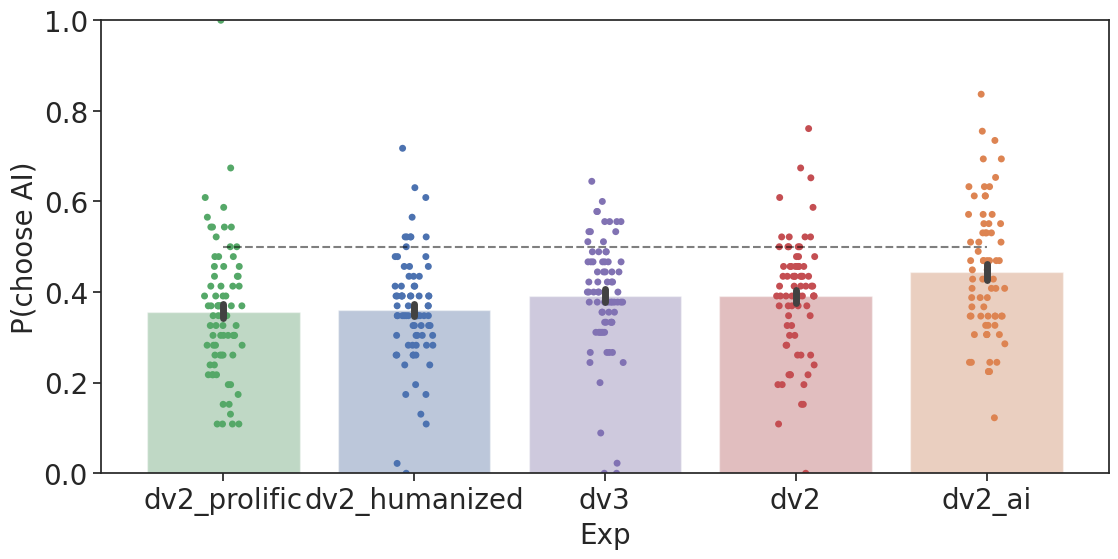

In [91]:
sns.set({'figure.figsize':(13, 6)})
sns.set_style("ticks")
order = ['dv2_prolific', 'dv2_humanized', 'dv3', 'dv2', 'dv2_ai']
colors = ['C2', 'C0', 'C4', 'C3', 'C1']
dff = df.copy()
dff.loc[dff.answer=='Not Prolific', 'answer'] = 'AI'
dff.loc[dff.q_id==2, 'chooseAI'] = dff[dff.q_id==2].answer=='AI'
df2 = dff[dff.q_id==2].groupby(['prolific_id', 'engine'], as_index=False).chooseAI.mean()

sns.barplot(x='engine', y='chooseAI', data=df2,  ci=68, errwidth=5, alpha=0.4, zorder=0, order=order, palette=colors)
sns.stripplot(x='engine', y='chooseAI', data=df2,zorder=1, order=order, palette=colors)
plt.plot([0, 4], [0.5, 0.5], '--', color='black', alpha=0.5)
plt.ylabel('P(choose AI)')
plt.ylim(0, 1)
plt.xlabel('Exp')
# pg.ttest(df2[df2.engine=='dv2_humanized'].correct, df2[df2.engine=='dv2_ai'].correct)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# pg.pairwise_ttests(dv='correct', between='engine', subject='prolific_id', data=df2, padjust='bonf', effsize='cohen', parametric=True)

<AxesSubplot:xlabel='engine', ylabel='correct'>

<AxesSubplot:xlabel='engine', ylabel='correct'>

(0.0, 1.0)

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,engine,dv2,dv2_ai,False,True,2.6147,138.4940,two-sided,0.0099,0.0992,bonf,3.902,0.4242
1,engine,dv2,dv2_humanized,False,True,4.3204,129.4213,two-sided,0.0000,0.0003,bonf,669.252,0.6956
2,engine,dv2,dv2_prolific,False,True,1.9161,153.9989,two-sided,0.0572,0.5721,bonf,0.927,0.3067
3,engine,dv2,dv3,False,True,-3.1782,149.5827,two-sided,0.0018,0.0180,bonf,16.51,-0.5142
4,engine,dv2_ai,dv2_humanized,False,True,1.8884,142.8580,two-sided,0.0610,0.6100,bonf,0.894,0.3093
5,engine,dv2_ai,dv2_prolific,False,True,-0.4314,140.5983,two-sided,0.6669,1.0000,bonf,0.191,-0.0692
6,engine,dv2_ai,dv3,False,True,-6.0150,131.2002,two-sided,0.0000,0.0000,bonf,7.551e+05,-0.9789
7,engine,dv2_humanized,dv2_prolific,False,True,-2.0083,156.0000,two-sided,0.0463,0.4634,bonf,1.088,-0.3195
8,engine,dv2_humanized,dv3,False,True,-7.7633,121.0037,two-sided,0.0000,0.0000,bonf,5.79e+09,-1.2591
9,engine,dv2_prolific,dv3,False,True,-4.9912,151.4819,two-sided,0.0000,0.0000,bonf,9024.788,-0.8029


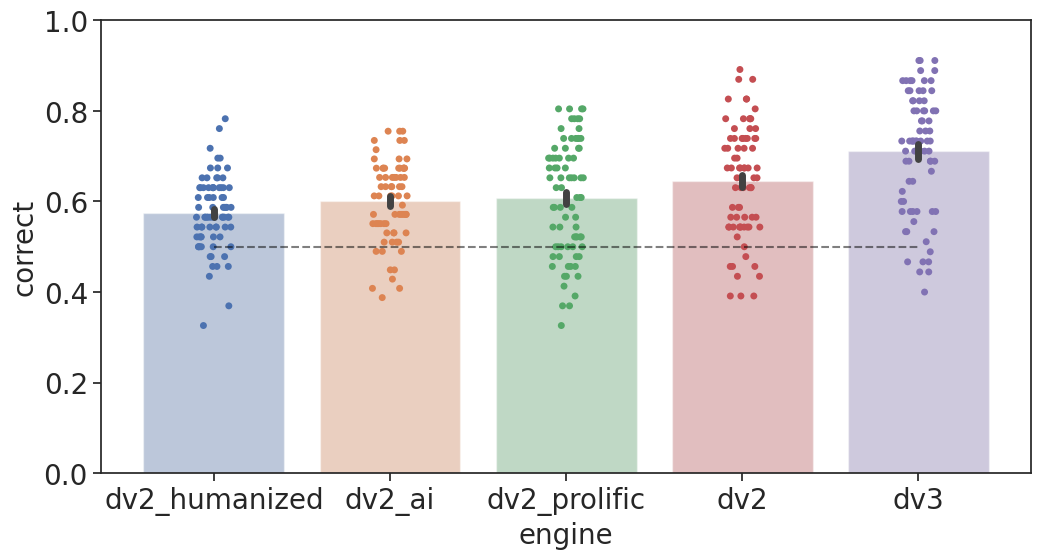

In [92]:
sns.set({'figure.figsize':(12, 6)})
sns.set_style("ticks")
df2 = df[df.q_id==2].groupby(['prolific_id', 'engine'], as_index=False).correct.mean()

sns.barplot(x='engine', y='correct', data=df2, order=['dv2_humanized', 'dv2_ai', 'dv2_prolific', 'dv2', 'dv3'], ci=68, errwidth=5, alpha=0.4, zorder=0)
sns.stripplot(x='engine', y='correct', data=df2, order=['dv2_humanized', 'dv2_ai', 'dv2_prolific', 'dv2', 'dv3'], zorder=1)
plt.plot([0, 4], [0.5, 0.5], '--', color='black', alpha=0.5)
plt.ylim(0, 1)
# pg.ttest(df2[df2.engine=='dv2_humanized'].correct, df2[df2.engine=='dv2_ai'].correct)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pg.pairwise_ttests(dv='correct', between='engine', subject='prolific_id', data=df2, padjust='bonf', effsize='cohen', parametric=True)

In [77]:
df_all = pd.read_csv('H+GPT3/all_final.csv')
sns.set(
    rc={'figure.figsize':(23,12), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 13
        , 'ytick.labelsize': 13, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})

df_all['agree_a0'] = df_all.a0.str.contains('yes')
df_AI = df_all[df_all.source=='AI'].groupby(['title', 'cond'], as_index=False).agree_a0.mean().sort_values('title', ascending=False).rename(columns={'agree_a0': 'AI'})
df_Human = df_all[df_all.source=='Human'].groupby(['title', 'cond'], as_index=False).agree_a0.mean().sort_values('title', ascending=False).rename(columns={'agree_a0': 'H'})
diff = pd.concat([df_AI, df_Human.H], axis=1)
diff['diff'] = diff.AI - diff.H
# df_AI.drop('item_id', axis=1, inplace=True)
# df_Human.drop('item_id', axis=1, inplace=True)
# corr.corr()
diff['item_id'] = diff.index


# plt.subplot(2, 1, 1)
# sns.barplot(x='item_id', y='diff', data=diff, hue='cond', order=diff.sort_values(['diff', 'cond'], ascending=False).index)
# plt.ylabel('delta (AI - Human) agreement')
# # sns.heatmap(abs(df_AI.AI - df_Human.H), annot=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1, cbar=False)

# plt.subplot(2, 2, 3)
# sns.scatterplot(x='AI', y='H', data=diff, hue='cond', legend=False)
# plt.annotate(f'corr={round(diff.corr().H.values[0], 2)}', xy=(.2, .5))


## add similarity score to df where title is the same in diff
# check if diff.title contains Sophie's Choice 
df.loc[df['title'].str.contains('Sophie'), 'title'] = 'Sophie Choice'
diff.loc[diff['title'].str.contains('Sophie'), 'title'] = 'Sophie Choice'
df['sim_score'] = df.title.apply(lambda x: diff[diff.title.str.contains(x)]['diff'].values[0])




/tmp/ipykernel_2276/1597501882.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')
/tmp/ipykernel_2276/1597501882.py:79: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg = df[(df.engine==engine)].groupby(['prolific_id', 'source'], as_index=False).mean()
/tmp/ipykernel_2276/1597501882.py:122: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


Text(0.5, 1.05, 'dv2_humanized')

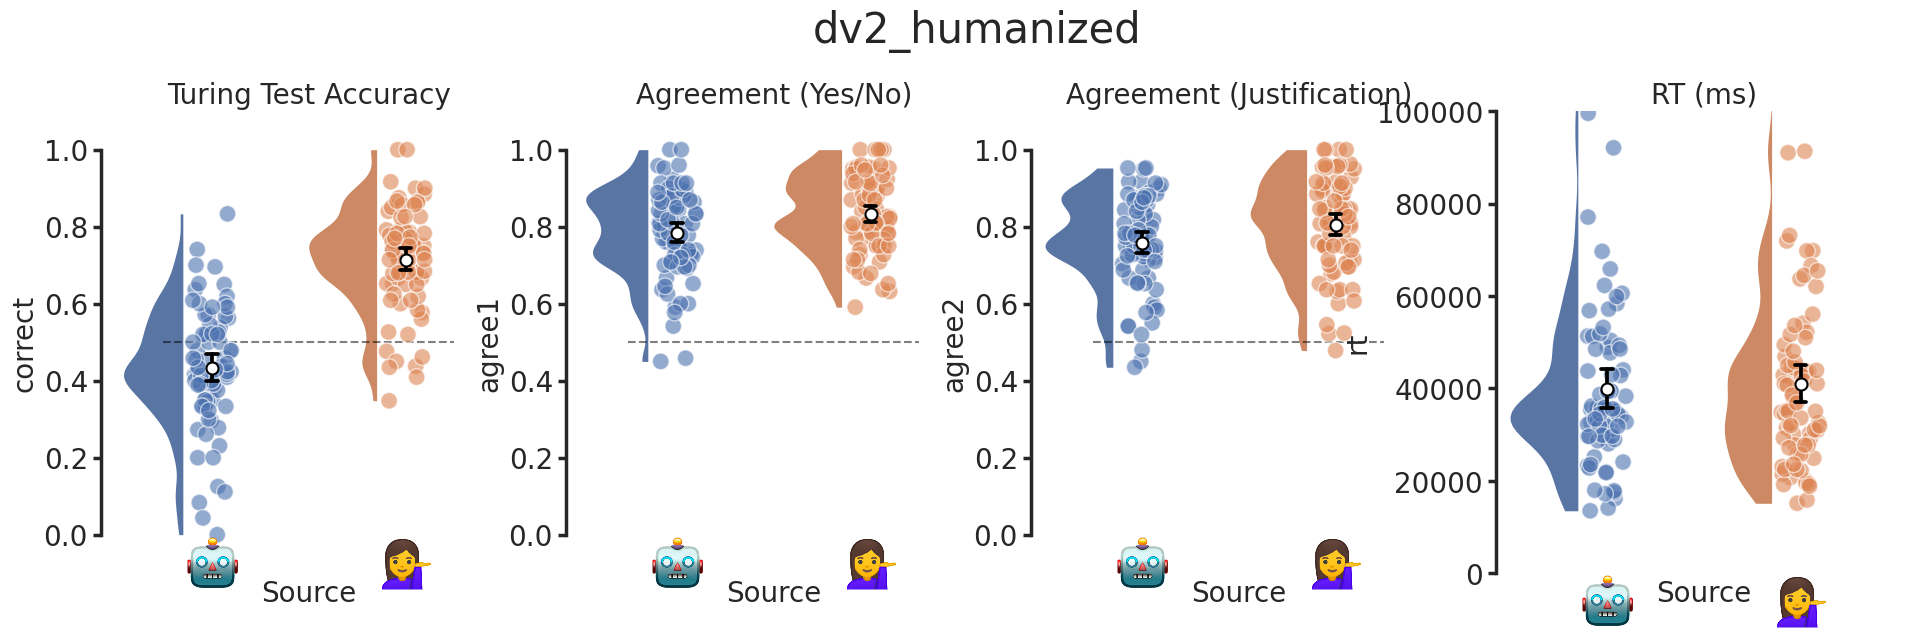

In [64]:
sns.set(
    rc={'figure.figsize':(23,6), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5

engine = 'dv2_humanized'

# -------------------------------------------------------------------------------
# Plot 1: Turing Test 
# -------------------------------------------------------------------------------
avg = df[(df.engine==engine)& (df.q_id==2)].groupby(['prolific_id', 'source'], as_index=False).correct.mean()
plt.subplot(1, 4, 1)
# sns.barplot(x='source', y='correct', data=avg, errorbar='se'
# sns.stripplot(x='source', y='correct', data=avg, alpha=0.5, jitter=0.1, size=15, color='black')
#
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='correct', markersize=12, df=avg)
plt.ylim(0, 1)
plt.ylim(-.1, 1.1)
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.title('Turing Test Accuracy')
plt.xticks([])
plt.gca().spines['left'].set_linewidth(2.5)
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);

plt.xlabel('Source')

# AI correct and Human correct is significantly diff
# print(pg.ttest(avg[avg.source=='AI'].correct, avg[avg.source=='Human'].correct, paired=True))
# n = len(avg[avg.source=='AI'].correct)
# print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='AI'].correct))
# print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='Human'].correct))

# -------------------------------------------------------------------------------
# Plot 2: Agreement 1
# -------------------------------------------------------------------------------
avg = df[(df.engine==engine)].groupby(['prolific_id', 'source'], as_index=False).agree1.mean()
plt.subplot(1, 4, 2)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='agree1', markersize=12, df=avg)
# sns.barplot(x='source', y='agree1', data=avg, errorbar='se')
# sns.stripplot(x='source', y='agree1', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
plt.ylim(0, 1)
plt.ylim(-.1, 1.1)
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.title('Agreement (Yes/No)')
plt.xticks([])
plt.gca().spines['left'].set_linewidth(2.5)
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
# AI agree1 and Human agree1 is significantly diff
sources = avg.source.unique()

plt.xlabel('Source')
# print(f'{sources[0]} vs {sources[1]}')
# print(pg.ttest(avg[avg.source==sources[0]].agree1, avg[avg.source==sources[1]].agree1, paired=True))
# n = len(avg[avg.source=='AI'].correct)
# print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='AI'].correct))
# print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='Human'].correct))

# -------------------------------------------------------------------------------
# Plot 3: Agreement 2
# -------------------------------------------------------------------------------
avg = df[(df.engine==engine)].groupby(['prolific_id', 'source'], as_index=False).mean()
plt.subplot(1, 4, 3)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='agree2', markersize=12, df=avg)
# sns.barplot(x='source', y='agree2', data=avg, errorbar='se')
# sns.stripplot(x='source', y='agree2', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
plt.ylim(-.1, 1.1)
plt.title('Agreement (Justification)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.xticks([])
plt.xlabel('Source')
# AI agree2 and Human agree2 is significantly diff
# print(pg.ttest(avg[avg.source=='AI'].agree2, avg[avg.source=='Human'].agree2, paired=True))


# -------------------------------------------------------------------------------
# Plot 4: RT
# -------------------------------------------------------------------------------
plt.subplot(1, 4, 4)
# plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# plt.plot([-1, 2], [0.5, 0.5], '--', color='black', alpha=0.5)
#sns.barplot(x='source', y='rt', data=avg, errorbar='se')
#sns.stripplot(x='source', y='rt', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
raincloud(x='source', y='rt', markersize=12, df=avg)
plt.ylim(0, 100000)
plt.title('RT (ms)')
plt.xlabel('')
plt.xticks([])
plt.gca().spines['left'].set_linewidth(2.5)

for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)

sns.despine(offset=10, trim=True, bottom=True);
plt.xlabel('Source')


plt.tight_layout()
plt.suptitle(engine, fontsize=30, y=1.05)

# ADD CORRECTNESS SCORE

In [5]:
import html
def rule(x):
   dic = ['HIV', 'Mrs', 'VCR', 'Monday', 'Santiago', 'Morris']
   err = []
   for m in tool.check(x):
         if m.category in ('TYPOS', 'GRAMMAR') and m.ruleId not in ('UPPERCASE_SENTENCE_START', 'I_LOWERCASE'):
            if any(el in m.replacements for el in dic): 
               continue
            err.append(m)
   return len(err)

# df = df[df.engine=='dv2_ai']
df['a1'] = df.a1.apply(html.unescape)
unique_a1 = df.a1.unique()
new_df = pd.DataFrame({'a1': unique_a1, 'errors': [None, ]*len(unique_a1)})

with ltp.LanguageTool('en-US', remote_server='http://localhost:8081') as tool:
    new_df['errors'] = new_df.a1.apply(rule)
print('Finished checking correctness, apply to dv2 and dv3')
df['errors'] = df.a1.apply(lambda x: new_df[new_df.a1==x].errors.values[0])
df.to_csv('dv_with_errors.csv')
#dv3['correctness'] = dv3.a1.apply(lambda x: new_df[new_df.a1==x].correctness.values[0])
#dv2.to_csv('HUMANS/dv2_77.csv')
#dv3.to_csv('HUMANS/dv3_76.csv')
# df[df.engine=='dv2_humanized'].to_csv('dv2_humanized_correctness.csv')

Finished checking correctness, apply to dv2 and dv3


Text(0, 0.5, 'Errors')

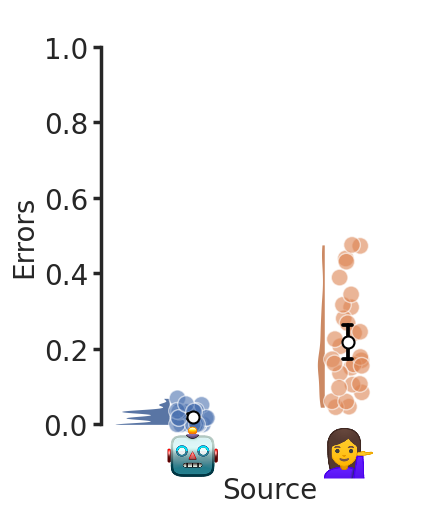

In [83]:
import html 
sns.set(
    rc={'figure.figsize':(4,6), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png')

plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5
# set width axis spines
plt.rcParams['axes.linewidth'] = 2.5

engine = 'dv2'
df.a1 = df.a1.apply(html.unescape)
df2 = df[df.engine==engine].groupby(['respondent_id', 'source'], as_index=False).mean()

raincloud(x='source', y='correctness', markersize=12, df=df2)
# plt.ylim(0, 1)
plt.ylim(-.1, 1.1)
plt.xticks(range(2), ('', ''))
plt.xlabel('')
# plt.title('Turing Test Accuracy')
plt.xticks([])
plt.gca().spines['left'].set_linewidth(2.5)
for i, c in enumerate(df2.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);

plt.xlabel('Source')
plt.ylabel('Errors')


/tmp/ipykernel_2276/3759249165.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df[df.engine==engine].groupby(['prolific_id', 'answer'], as_index=False).mean()


<Axes: >

Index(['AI', 'Not an AI'], dtype='object', name='answer')


(-0.1, 1.1)

([<matplotlib.axis.XTick at 0x7f836f9e8d90>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

Text(0.5, 1.0, '')

([], [])

Text(0.5, 0, 'answer')

Text(0, 0.5, 'P(agree)')

Text(0.5, 1.0, 'Agreement (yes/no)')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.828691,71,two-sided,0.071646,"[-0.11, 0.0]",0.34063,0.627,0.813557


<Axes: >

Index(['AI', 'Not an AI'], dtype='object', name='answer')


(-0.1, 1.1)

([<matplotlib.axis.XTick at 0x7f836f75edd0>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

Text(0.5, 1.0, '')

([], [])

Text(0.5, 0, 'answer')

Text(0, 0.5, 'P(agree)')

Text(0.5, 1.0, 'Agreement (justification)')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.828691,71,two-sided,0.071646,"[-0.11, 0.0]",0.34063,0.627,0.813557


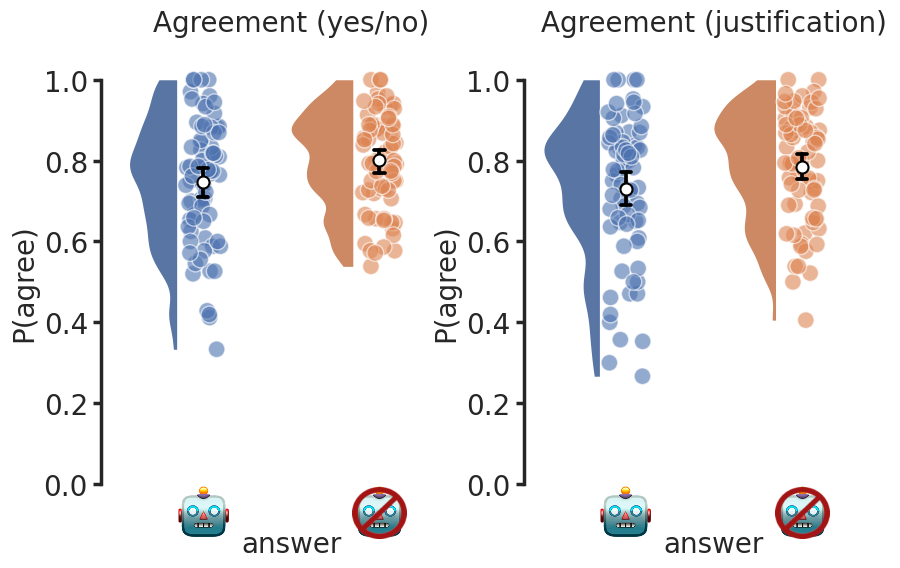

In [120]:
sns.set(
    rc={'figure.figsize':(10,6.3), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png')

plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5
# set width axis spines
plt.rcParams['axes.linewidth'] = 2.5

engine = 'dv2_ai'

df2 = df[df.engine==engine].groupby(['prolific_id', 'answer'], as_index=False).mean()
# df2.loc[df2.answer=='AI', 'answer'] = 'AI_humanized'
titles = ['Agreement (yes/no)', 'Agreement (justification)']
count = 0
for agree in ('agree1', 'agree2'):
    plt.subplot(1, 2, count+1)

    raincloud(x='answer', y=agree, markersize=12, df=df2)
# plt.ylim(0, 1)
    plt.ylim(-.1, 1.1)
    plt.xticks(range(2), ('', ''))
    plt.xlabel('')
    plt.title('')
    plt.xticks([])
    plt.gca().spines['left'].set_linewidth(2.5)
    for i, c in enumerate(df2.answer.unique()):
        offset_image(i, c, plt.gca(), size=0.3)
    sns.despine(offset=10, trim=True, bottom=True);

    plt.xlabel('answer')
    plt.ylabel('P(agree)')
    plt.title(titles[count])
    
    pg.ttest(x=df2[df2.answer=='AI'].agree2, y=df2[df2.answer=='Not an AI'].agree2, paired=True)
    count += 1


/tmp/ipykernel_2276/3724975320.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')
/tmp/ipykernel_2276/3724975320.py:36: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  false['id'] = 1 - df[mask_Human].groupby('prolific_id', as_index=False).mean().correct
/tmp/ipykernel_2276/3724975320.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  false['engine'] = df[mask_Human].groupby(['prolific_id', 'engine'], as_index=False).mean().engine
/tmp/ipykernel_2276/3724975320.py:38: F

['Human' 'AI' 'AI_humanized']


/tmp/ipykernel_2276/3724975320.py:54: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  'prolific_id', as_index=False).mean().agree2
/tmp/ipykernel_2276/3724975320.py:68: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  d = d[~d.isin([np.nan, np.inf, -np.inf]).any(1)]


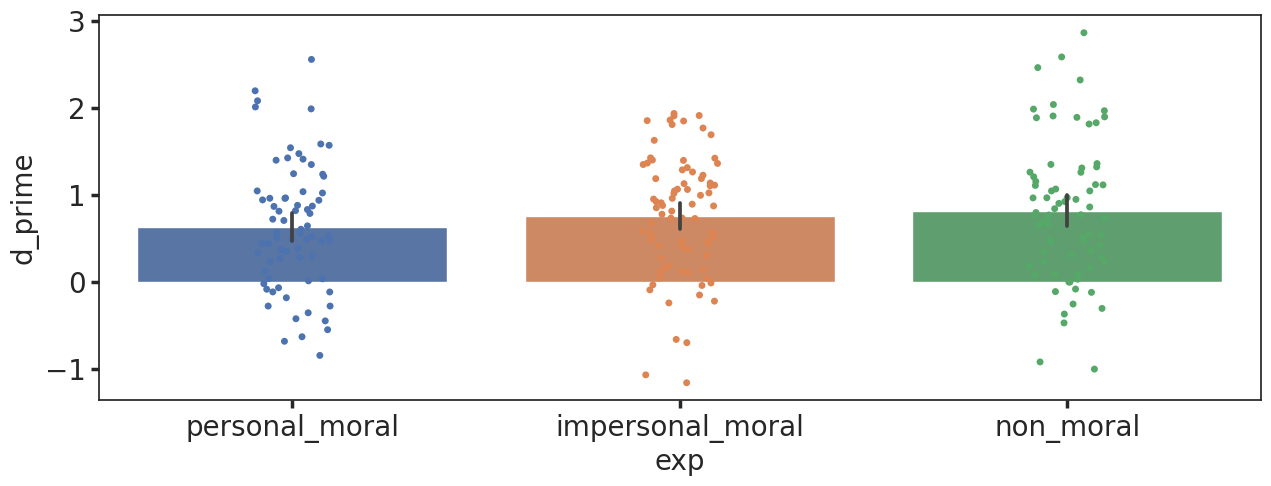

           n         r         CI95%    p-val   BF10     power
pearson  227 -0.074626  [-0.2, 0.06]  0.26284  0.155  0.201729
                            OLS Regression Results                            
Dep. Variable:                 agree1   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.260
Date:                Mon, 26 Jun 2023   Prob (F-statistic):              0.263
Time:                        00:05:14   Log-Likelihood:                 171.01
No. Observations:                 227   AIC:                            -338.0
Df Residuals:                     225   BIC:                            -331.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----

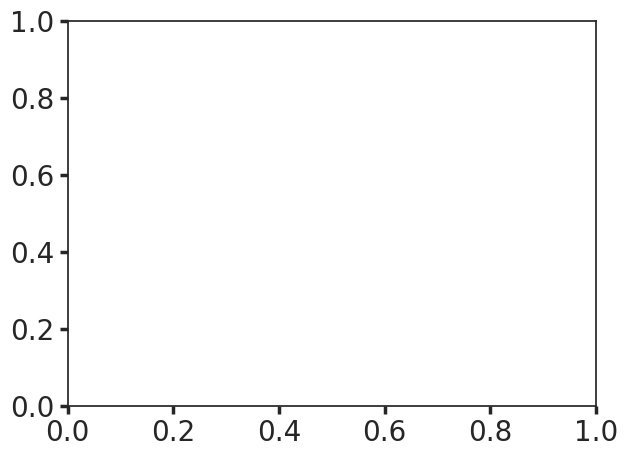

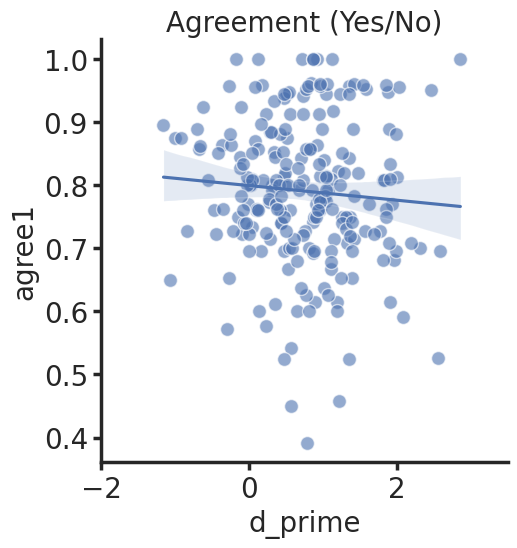

           n         r         CI95%     p-val   BF10     power
pearson  227 -0.068811  [-0.2, 0.06]  0.301958  0.141  0.178393
                            OLS Regression Results                            
Dep. Variable:                 agree2   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.070
Date:                Mon, 26 Jun 2023   Prob (F-statistic):              0.302
Time:                        00:05:15   Log-Likelihood:                 135.51
No. Observations:                 227   AIC:                            -267.0
Df Residuals:                     225   BIC:                            -260.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

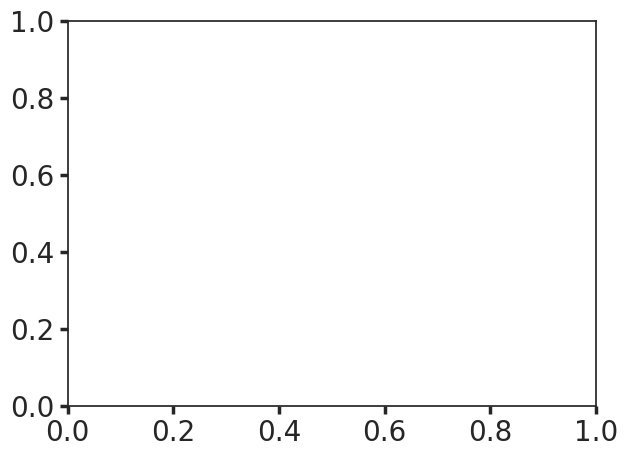

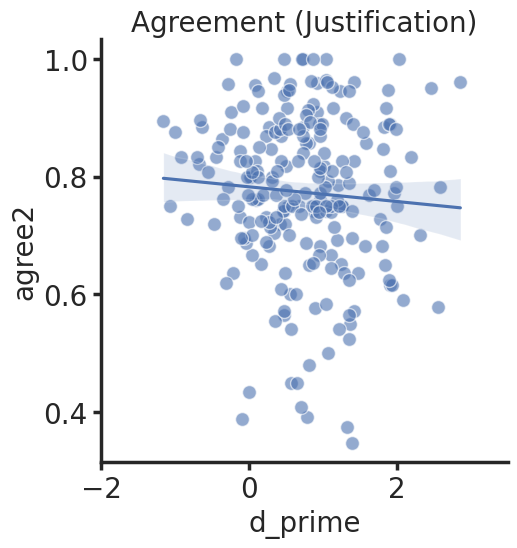

In [102]:
import scipy.stats as stats

sns.set(
    rc={'figure.figsize':(35,6), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5

false = pd.DataFrame()
hits = pd.DataFrame()

df['correct'] = df.correct.astype(int)
df['agree1'] = df.agree1.astype(int)
df['agree2'] = df.agree2.astype(int)

labels = ['id', 'agree1', 'agree2']
labels = ['id']
titles = ['Agreement (Yes/No)', 'Agreement (Justification)']
# titles = ['Control  p(correct) ~ d_prime']


print(df.source.unique())

mask_AI = (df.source=='AI') & (df.q_id == 2)
mask_Human = (df.source == 'Human') & (df.q_id == 2)

false['id'] = 1 - df[mask_Human].groupby('prolific_id', as_index=False).mean().correct
false['engine'] = df[mask_Human].groupby(['prolific_id', 'engine'], as_index=False).mean().engine
false['cond'] = df[mask_Human].groupby(['prolific_id', 'cond'], as_index=False).mean().cond
false['prolific_id'] = df[mask_Human].groupby('prolific_id', as_index=False).mean().prolific_id

hits['id'] = df[mask_AI].groupby(
    'prolific_id', as_index=False).mean().correct
hits['engine'] = df[mask_AI].groupby(['prolific_id', 'engine'],as_index=False).mean().engine
hits['cond'] = df[mask_AI].groupby(['prolific_id', 'cond'],as_index=False).mean().cond
hits['prolific_id'] = df[mask_AI].groupby('prolific_id', as_index=False).mean().prolific_id

false['agree1'] = 1 - df[mask_AI].groupby('prolific_id', as_index=False).mean().agree1

hits['agree1'] = df[mask_AI].groupby(
    'prolific_id', as_index=False).mean().agree1
false['agree2'] = 1 - df[mask_Human
].groupby('prolific_id', as_index=False).mean().agree2
hits['agree2'] = df[mask_AI].groupby(
    'prolific_id', as_index=False).mean().agree2

d = []
for i in range(false['id'].shape[0]):
    d.append({'agree1': hits['agree1'].values[i],
              'agree2': hits['agree2'].values[i],
              'engine': hits['engine'].values[i],
              'prolific_id': hits['prolific_id'].values[i],
              'correct': hits['id'].values[i],
              'cond': hits['cond'].values[i],
              'd_prime': float(stats.norm.ppf(hits['id'].values[i]) - stats.norm.ppf(false['id'].values[i]))})


d = pd.DataFrame(d)  # plt.subplot(1, 4, 1)
d = d[~d.isin([np.nan, np.inf, -np.inf]).any(1)]
d = d[d.engine != 'dv2_ai']
sns.set({'figure.figsize': (15,5), "figure.dpi": 100, 'legend.fontsize': 20,})
sns.set_style('ticks')
# sns.barplot(x='cond', y='d_prime', data=d, ci=68, alpha=.5, errwidth=2.5, edgecolor='white', order=['dv2_humanized','dv2_prolific', 'dv2_ai', 'dv2', 'dv3'], zorder=0)
# sns.barplot(x='cond', y='d_prime', data=d, ci=68, alpha=.5, errwidth=2.5, edgecolor='white', order=['dv2_humanized','dv2_prolific', 'dv2_ai', 'dv2', 'dv3'], zorder=0)
sns.barplot(x='cond', y='d_prime', data=d, edgecolor='white', zorder=1)
sns.stripplot(x='cond', y='d_prime', data=d, edgecolor='white', zorder=1)
plt.xlabel('exp')
# plt.ylim(0,1.5)
plt.show()

# d = d[d.engine=='dv2']
count = 0
d['d_prime'] = d['d_prime'].astype(float)
d['agree1'] = d['agree1'].astype(float)
for agree in ('agree1', 'agree2'):
    count += 1
    # plt.clear()
    plt.subplot(1, 2, count)
    sns.lmplot(x='d_prime', y=agree, data=d, scatter_kws={
               'alpha': 0.6, 's': 100, 'edgecolor': 'white'})
# snspine(offset=10, trim=True)
    plt.gca().spines['left'].set_linewidth(2.5)
    plt.gca().spines['bottom'].set_linewidth(2.5)
    plt.xlim([-2, 3.5])
    plt.title(titles[count-1])
    print(pg.corr(d['d_prime'], d[agree]))
    print(sm.formula.ols(f'{agree} ~ d_prime', data=d).fit().summary())
    plt.show()

# add d_prime to the original dataframe to the corresponding prolific_id
def f(x):
    try:
        return d[d.prolific_id == x.prolific_id].d_prime.values[0]
    except:
        return np.NaN

df['d_prime'] = df.apply(f, axis=1)

/tmp/ipykernel_2276/1580003716.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ].groupby(['prolific_id', 'answer'], as_index=False).mean()


                            OLS Regression Results                            
Dep. Variable:           anti_AI_bias   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.334
Date:                Mon, 26 Jun 2023   Prob (F-statistic):              0.131
Time:                        01:12:05   Log-Likelihood:                -1.2052
No. Observations:                  72   AIC:                             6.410
Df Residuals:                      70   BIC:                             10.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2659      0.142      1.878      0.0

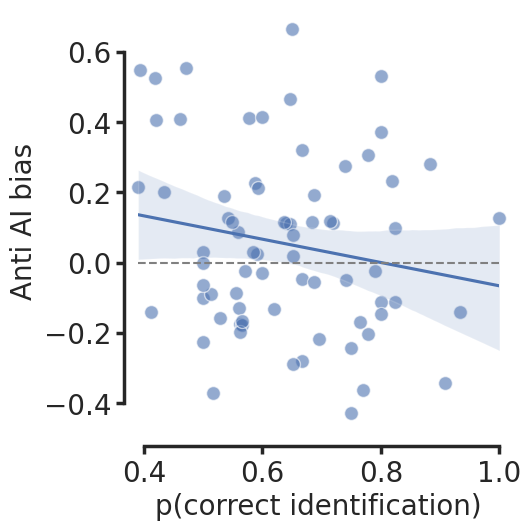

In [123]:
import scipy.stats as stats

sns.set(
    rc={'figure.figsize':(6, 6), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5
# axes width
plt.rcParams['axes.linewidth'] = 2.5


df2 = df[
    # (df.source == 'AI')
    (df.q_id == 2)
    & (df.engine =='dv2_ai')
].groupby(['prolific_id', 'answer'], as_index=False).mean()

new_df = []
for i in df2.prolific_id.unique():
    try:
        new_df.append({
            'd_prime': df2[df2.prolific_id == i].correct.values[0],
            'anti_AI_bias': df2[(df2.answer=='Not an AI') & (df2.prolific_id==i)].agree2.values[0] - df2[(df2.answer=='AI') & (df2.prolific_id==i)].agree2.values[0]
        })

    except Exception as e:
        print(e)
        continue

new_df = pd.DataFrame(new_df)

# dotted line at 0
sns.lmplot(x='d_prime', y='anti_AI_bias', data=new_df, scatter_kws=
           {'clip_on': False, 'alpha': 0.6, 's': 100, 'edgecolor': 'white'})

plt.axhline(0, ls='--', color='grey')
plt.xlabel('p(correct identification)')
plt.ylabel('Anti AI bias')
print(sm.formula.ols('anti_AI_bias ~ d_prime', data=new_df).fit().summary())
# plt.xlim(0.2, 1)
sns.despine(offset=10, trim=True)
# new_df.corr()

/tmp/ipykernel_2276/3868450676.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df[df.engine.isin(['dv2', 'dv2_humanized', 'dv2_ai'])].groupby(['prolific_id', 'engine'], as_index=False).mean()


KeyError: 'Column not found: answer'

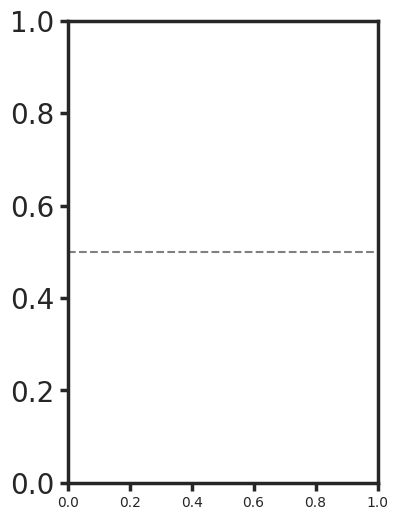

In [133]:
sns.set(
    rc={'figure.figsize':(4,6), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 10, 'ytick.labelsize': 20, 
        'font.sans-serif': 'Arial', 'text.usetex': False})
sns.set_style("ticks")

# increase x axis label size
plt.rcParams['ytick.major.width'] = 2.5
# increase y axis label size
plt.rcParams['xtick.major.width'] = 2.5
# axis width
plt.rcParams['axes.linewidth'] = 2.5

# horizontal line at .5
plt.axhline(0.5, ls='--', color='grey')
df2 = df[df.engine.isin(['dv2', 'dv2_humanized', 'dv2_ai'])].groupby(['prolific_id', 'engine'], as_index=False).mean()
raincloud(x='engine', y='answer', df=df2, markersize=7, order=['dv2', 'dv2_ai', 'dv2_humanized'])
plt.ylabel('p(correct identification)')

sns.despine(offset=10, trim=True)


/tmp/ipykernel_33932/3803845192.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dd = df[(df.engine=='dv2') & (df.source=='AI')].groupby(['prolific_id', 'cond'], as_index=False).mean()
/tmp/ipykernel_33932/3803845192.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dd = df[(df.engine=='dv2') & (df.source=='Human')].groupby(['prolific_id', 'cond'], as_index=False).mean()


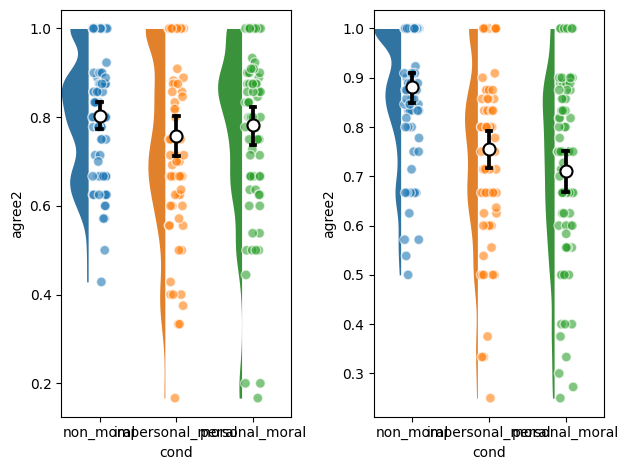

In [26]:
# df.engine.unique()

dd = df[(df.engine=='dv2') & (df.source=='AI')].groupby(['prolific_id', 'cond'], as_index=False).mean()
plt.subplot(1, 2, 1)
raincloud(x='cond', y='agree2', df=dd, markersize=7, order=['non_moral', 'impersonal_moral', 'personal_moral'])
dd = df[(df.engine=='dv2') & (df.source=='Human')].groupby(['prolific_id', 'cond'], as_index=False).mean()
plt.subplot(1, 2, 2)
raincloud(x='cond', y='agree2', df=dd, markersize=7, order=['non_moral', 'impersonal_moral', 'personal_moral'])
plt.tight_layout()

<Axes: xlabel='source', ylabel='correctness'>

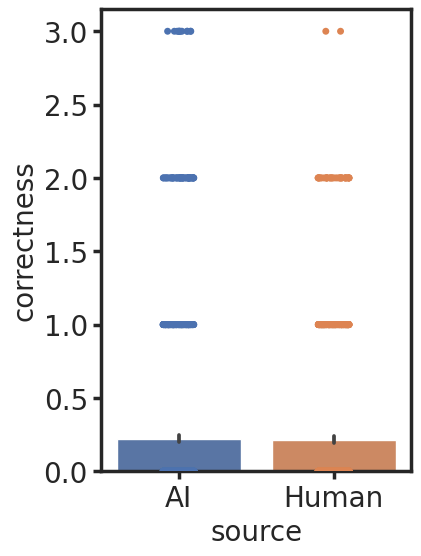

In [61]:
sns.barplot(x='source', y='correctness', data=df[df.engine=='dv2_humanized'])
#stripplot
sns.stripplot(x='source', y='correctness', data=df[df.engine=='dv2_humanized'], edgecolor='white')

['AI' 'Human']
Optimization terminated successfully.
         Current function value: 0.651881
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      a   No. Observations:                 3634
Model:                          Logit   Df Residuals:                     3631
Method:                           MLE   Df Model:                            2
Date:                Sun, 25 Jun 2023   Pseudo R-squ.:                0.002536
Time:                        22:57:54   Log-Likelihood:                -2368.9
converged:                       True   LL-Null:                       -2375.0
Covariance Type:            nonrobust   LLR p-value:                  0.002420
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.7306      0.080      9.087      0.000       0.573       0.888
correctness

/tmp/ipykernel_2276/3584406496.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.loc[dff.answer=='AI', 'a'] = 0
/tmp/ipykernel_2276/3584406496.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['agree1'] = dff['agree1'].astype(float)


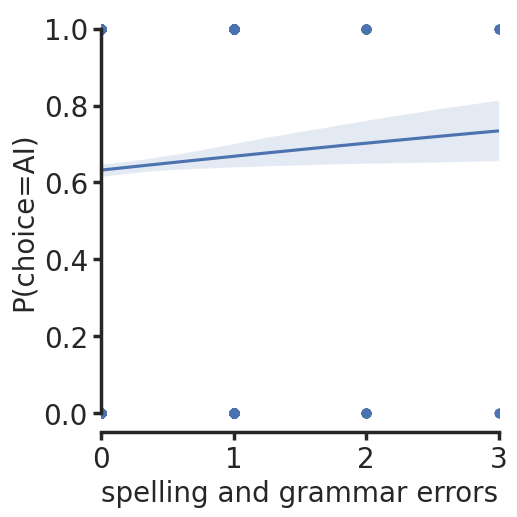

In [53]:
sns.set(
    rc={'figure.figsize':(4,6), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png')

plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5
# set width axis spines
plt.rcParams['axes.linewidth'] = 2.5


engine = 'dv2_humanized'
df['justif_len'] = df.a1.str.len()
dff = df[(df.q_id == 2) & (df.engine==engine)]

print(dff.answer.unique())
dff.loc[dff.answer=='AI', 'a'] = 0
dff.loc[dff.answer=='Human', 'a'] = 1

dff.loc[dff.agree1==True, 'agree1'] = 1
dff.loc[dff.agree1==False, 'agree1'] = 0

dff['agree1'] = dff['agree1'].astype(float)
print(sm.Logit.from_formula('a ~ correctness+justif_len', data=dff).fit().summary())
sns.lmplot(x='correctness', y='a', data=dff, logistic=True, scatter_kws={'alpha': 0.6})
plt.ylabel('P(choice=AI)')
# plt.xlabel('spelling and grammar errors')
# plt.xticks([0, 250, 500, 750, 1000, 1250])
plt.xlabel('spelling and grammar errors')
sns.despine(trim=True)

<AxesSubplot:xlabel='answer', ylabel='dataset_id'>

<AxesSubplot:xlabel='answer', ylabel='dataset_id'>

Text(0, 0.5, 'N trials')

Text(0.5, 1.0, 'dv2')

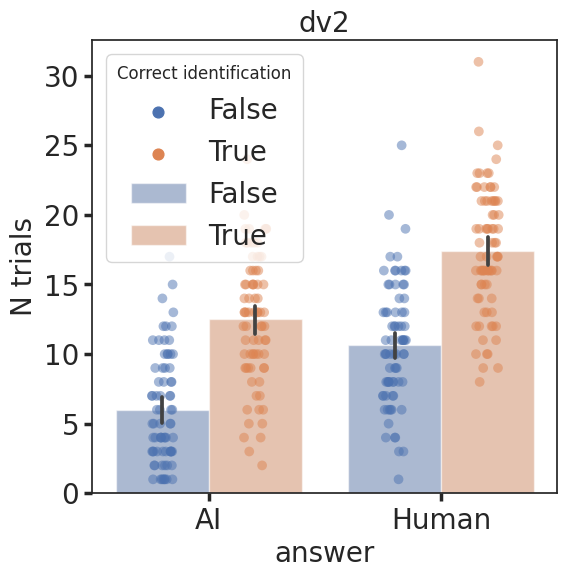

In [27]:
engine = 'dv2'
df2 = df[(df.engine==engine) & (df.q_id==2)].groupby(['prolific_id', 'answer', 'correct'], as_index=False).count()
sns.set({'figure.figsize':(6, 6), 'figure.dpi': 100, 'font.size': 13})
sns.set_style('ticks')


sns.barplot(x='answer', y='dataset_id', data=df2, hue='correct', dodge=True, alpha=.5, zorder=0)
sns.stripplot(x='answer', y='dataset_id', data=df2, alpha=0.5, jitter=0.1, size=7, hue='correct', dodge=True, zorder=1)
plt.ylabel('N trials')
plt.title(engine)    
plt.legend(title='Correct identification')

/tmp/ipykernel_2276/1336750805.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg = df[(df.engine==engine) & (df.q_id == 2) & (df.cond!='non_moral')].groupby(['prolific_id', 'source', 'correct'], as_index=False).mean()


Size of dv2_humanized dataset:  104.0
ANOVA: VAR=agree1, ENGINE=dv2_humanized
             Source        SS  ddof1  ddof2        MS         F     p-unc  \
0            source  0.004098      1     75  0.004098  0.130521  0.718908   
1           correct  0.008731      1     75  0.008731  0.293535  0.589570   
2  source * correct  0.394135      1     75  0.394135  6.714906  0.011485   

   p-GG-corr       ng2  eps  
0   0.718908  0.000297  1.0  
1   0.589570  0.000632  1.0  
2   0.011485  0.027738  1.0  
ANOVA: VAR=agree2, ENGINE=dv2_humanized
             Source        SS  ddof1  ddof2        MS         F     p-unc  \
0            source  0.012046      1     75  0.012046  0.264098  0.608830   
1           correct  0.038695      1     75  0.038695  1.058986  0.306754   
2  source * correct  0.622009      1     75  0.622009  7.219882  0.008875   

   p-GG-corr       ng2  eps  
0   0.608830  0.000680  1.0  
1   0.306754  0.002180  1.0  
2   0.008875  0.033932  1.0  


Text(0.5, 1.01, 'dv2_humanized')

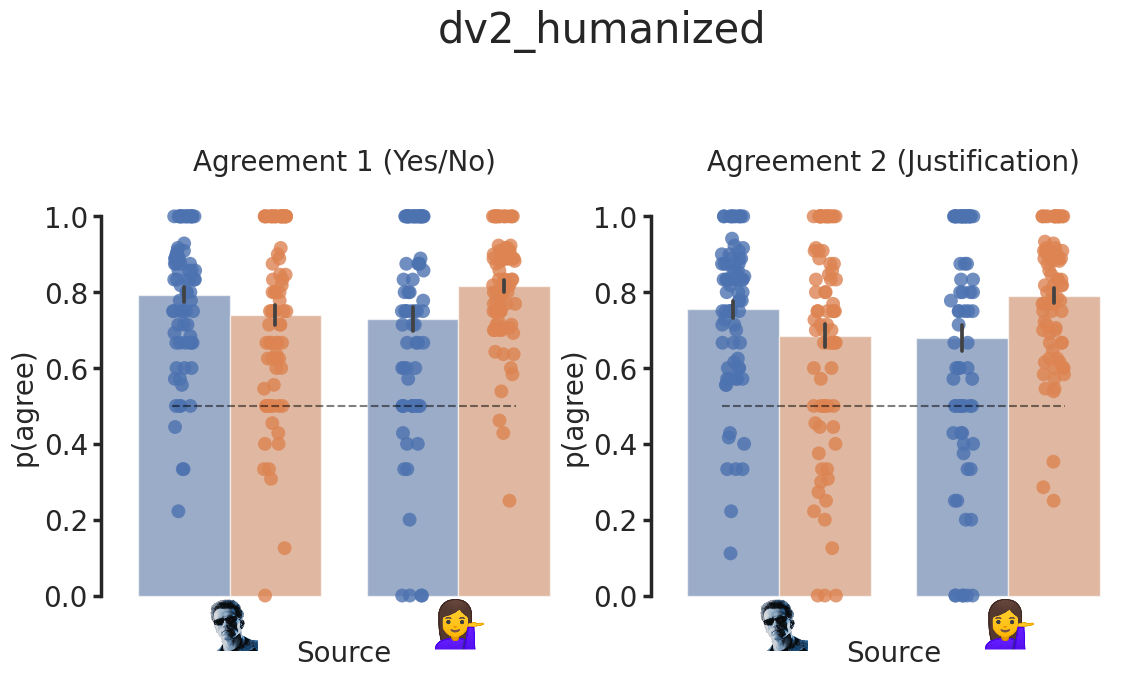

In [111]:

sns.set(
    rc={'figure.figsize':(13,13), "figure.dpi": 100, 'legend.fontsize': 20, 'axes.labelsize': 20, 'axes.titlesize': 20,
      'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and source + anova
# -------------------------------------------------------------------------------
engine = 'dv2_humanized'
# ids = np.random.choice(df[(df.engine==engine) & (df.q_id==2) & (df.cond!='non_moral')].prolific_id.unique(), 20, replace=False)
avg = df[(df.engine==engine) & (df.q_id == 2) & (df.cond!='non_moral')].groupby(['prolific_id', 'source', 'correct'], as_index=False).mean()
avg.loc[avg.source=='AI', 'source'] = 'AI_humanized'
print(f'Size of {engine} dataset: ', avg.shape[0]/3)

plt.subplot(2, 2, 1)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='source', y='agree1', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0, dodge=True)
sns.stripplot(x='source', y='agree1', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement 1 (Yes/No)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.ylabel('p(agree)')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)

plt.xlabel('Source')
# plt.legend([], [], frameon=False)
print(f'ANOVA: VAR=agree1, ENGINE={engine}')
print(pg.rm_anova(data=avg, dv='agree1', within=['source', 'correct'], subject='prolific_id', detailed=True))
plt.legend([], [], frameon=False)


# -------------------------------------------------------------------------------
# Plot:  agreement 2 per correct and source + anova
# ------------------------------------------------------------------------------
plt.subplot(2, 2, 2)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='source', y='agree2', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0)
sns.stripplot(x='source', y='agree2', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1, edgecolor='white')
plt.ylim(-.1, 1.1)
plt.title('Agreement 2 (Justification)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.ylabel('p(agree)')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.legend([], [], frameon=False)
plt.xlabel('Source')
print(f'ANOVA: VAR=agree2, ENGINE={engine}')
print(pg.rm_anova(data=avg, dv='agree2', within=['source', 'correct'], subject='prolific_id', detailed=True, correction='auto'))
plt.suptitle(engine, fontsize=30, y=1.01)

<AxesSubplot:>

Size of dv2 dataset:  101.0


<AxesSubplot:xlabel='answer', ylabel='agree1'>

<AxesSubplot:xlabel='answer', ylabel='agree1'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbee15e50>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'answer')

Text(0.5, 1.0, 'dv2')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-7.7221,214.0758,two-sided,0.0000,"[-0.22, -0.13]",0.8964,3.643e+10,1.0000


<AxesSubplot:>

Size of dv3 dataset:  96.33333333333333


<AxesSubplot:xlabel='answer', ylabel='agree1'>

<AxesSubplot:xlabel='answer', ylabel='agree1'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbedd1d30>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'answer')

Text(0.5, 1.0, 'dv3')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.9560,233.6013,two-sided,0.0001,"[-0.13, -0.04]",0.4743,194.272,0.9800


<AxesSubplot:>

Size of dv2_prolific dataset:  102.66666666666667


<AxesSubplot:xlabel='answer', ylabel='agree1'>

<AxesSubplot:xlabel='answer', ylabel='agree1'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbed39340>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'answer')

Text(0.5, 1.0, 'dv2_prolific')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-8.5289,193.8003,two-sided,0.0000,"[-0.26, -0.16]",0.9815,7.452e+12,1.0000


<AxesSubplot:>

Size of dv2_humanized dataset:  104.33333333333333


<AxesSubplot:xlabel='answer', ylabel='agree1'>

<AxesSubplot:xlabel='answer', ylabel='agree1'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbef2abe0>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'answer')

Text(0.5, 1.0, 'dv2_humanized')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.6532,245.5859,two-sided,0.0003,"[-0.11, -0.03]",0.4150,66.766,0.9554


<AxesSubplot:>

Size of dv2_ai dataset:  95.66666666666667


<AxesSubplot:xlabel='answer', ylabel='agree1'>

<AxesSubplot:xlabel='answer', ylabel='agree1'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbf012c10>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'answer')

Text(0.5, 1.0, 'dv2_ai')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.6909,275.9183,two-sided,0.0076,"[-0.09, -0.01]",0.3179,3.972,0.7653


ANOVA: VAR=agree1, ENGINE=dv2


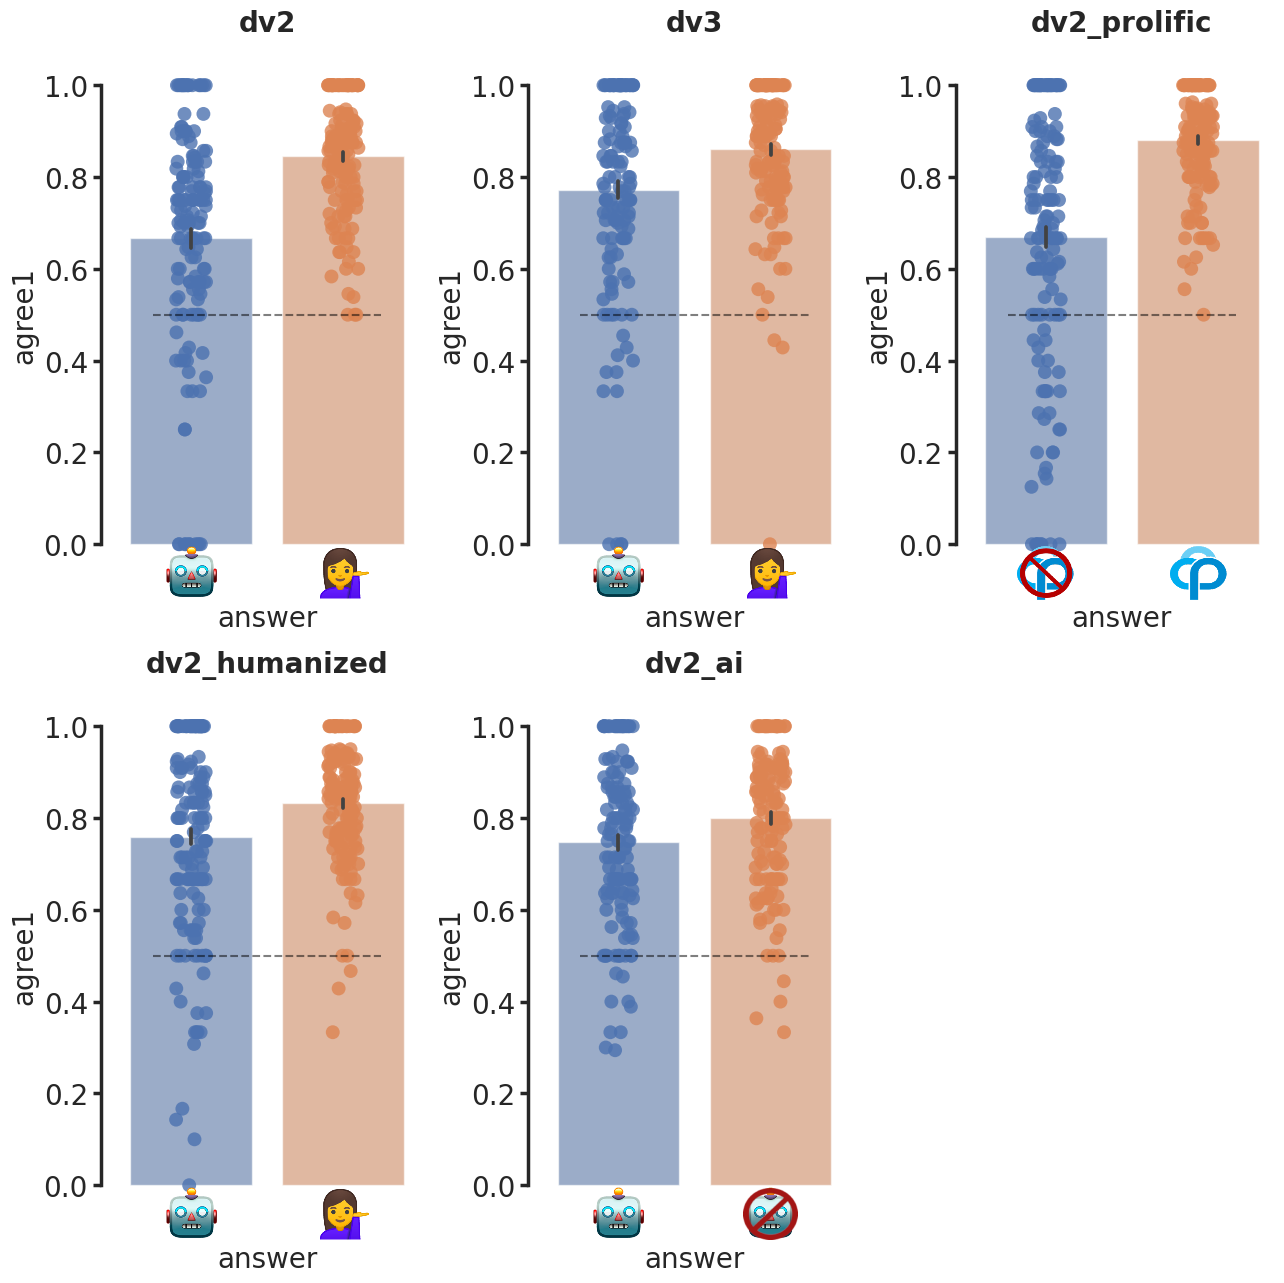

In [109]:
sns.set(
    rc={'figure.figsize':(13,13), "figure.dpi": 100, 'legend.fontsize': 20, 'axes.labelsize': 20, 'axes.titlesize': 20,
      'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")


count = 0
for engine in ['dv2', 'dv3', 'dv2_prolific', 'dv2_humanized', 'dv2_ai']:
    count += 1
    plt.subplot(2, 3, count)
#
# ids = np.random.choice(df[(df.engine==engine) & (df.q_id == 0) & (df.cond!='non_moral')].prolific_id.unique(), 22, replace=False)
    avg = df[(df.engine==engine) & (df.q_id == 2)].groupby(['prolific_id', 'answer', 'correct'], as_index=False).mean()
    print(f'Size of {engine} dataset: ', avg.shape[0]/3)
    # print(avg.answer.unique())
    plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
    sns.barplot(x='answer', y='agree1', data=avg, ci=68, alpha=0.6, zorder=0, dodge=True)
    sns.stripplot(x='answer', y='agree1', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, zorder=1)
    plt.ylim(-.1, 1.1)
    plt.title('Agreement 1 (Yes/No)')
    plt.xticks(range(2), ('', ''))
    plt.xlabel('')
    plt.xticks([])
    for i, c in enumerate(avg.answer.unique()):
        offset_image(i, c, plt.gca(), size=0.3)
    sns.despine(offset=10, trim=True, bottom=True);
    plt.gca().spines['left'].set_linewidth(2.5)
    plt.gca().spines['bottom'].set_linewidth(2.5)

    plt.xlabel('answer')
    plt.title(engine, fontweight='bold')
    answers = avg.answer.unique()
    pg.ttest(avg[avg.answer==answers[0]].agree1, avg[avg.answer==answers[1]].agree1, paired=True)
plt.tight_layout()
# plt.legend([], [], frameon=False)
print('ANOVA: VAR=agree1, ENGINE=dv2')
# pg.rm_anova(data=avg, dv='agree1', within=['source', 'correct'], subject='prolific_id', detailed=True)

<AxesSubplot:>

Size of dv2 dataset:  101.0


<AxesSubplot:xlabel='source', ylabel='agree2'>

<AxesSubplot:xlabel='source', ylabel='agree2'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbef30be0>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'source')

Text(0.5, 1.0, 'dv2')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.0967,262.8674,two-sided,0.2738,"[-0.02, 0.08]",0.1265,0.225,0.1952


<AxesSubplot:>

Size of dv3 dataset:  96.33333333333333


<AxesSubplot:xlabel='source', ylabel='agree2'>

<AxesSubplot:xlabel='source', ylabel='agree2'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbefd8e20>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'source')

Text(0.5, 1.0, 'dv3')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.4357,264.8011,two-sided,0.1523,"[-0.01, 0.08]",0.1702,0.345,0.3023


<AxesSubplot:>

Size of dv2_prolific dataset:  102.66666666666667


<AxesSubplot:xlabel='source', ylabel='agree2'>

<AxesSubplot:xlabel='source', ylabel='agree2'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbef8f400>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'source')

Text(0.5, 1.0, 'dv2_prolific')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.8883,303.7875,two-sided,0.3751,"[-0.08, 0.03]",0.1013,0.183,0.1437


<AxesSubplot:>

Size of dv2_ai dataset:  95.66666666666667


<AxesSubplot:xlabel='source', ylabel='agree2'>

<AxesSubplot:xlabel='source', ylabel='agree2'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbf1185b0>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'source')

Text(0.5, 1.0, 'dv2_ai')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.1466,282.3996,two-sided,0.8835,"[-0.04, 0.04]",0.0173,0.131,0.0525


<AxesSubplot:>

Size of dv2_humanized dataset:  104.33333333333333


<AxesSubplot:xlabel='source', ylabel='agree2'>

<AxesSubplot:xlabel='source', ylabel='agree2'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbf155d30>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'source')

Text(0.5, 1.0, 'dv2_humanized')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.3299,310.9997,two-sided,0.1845,"[-0.07, 0.01]",0.1503,0.29,0.2635


ANOVA: VAR=agree1, ENGINE=dv2


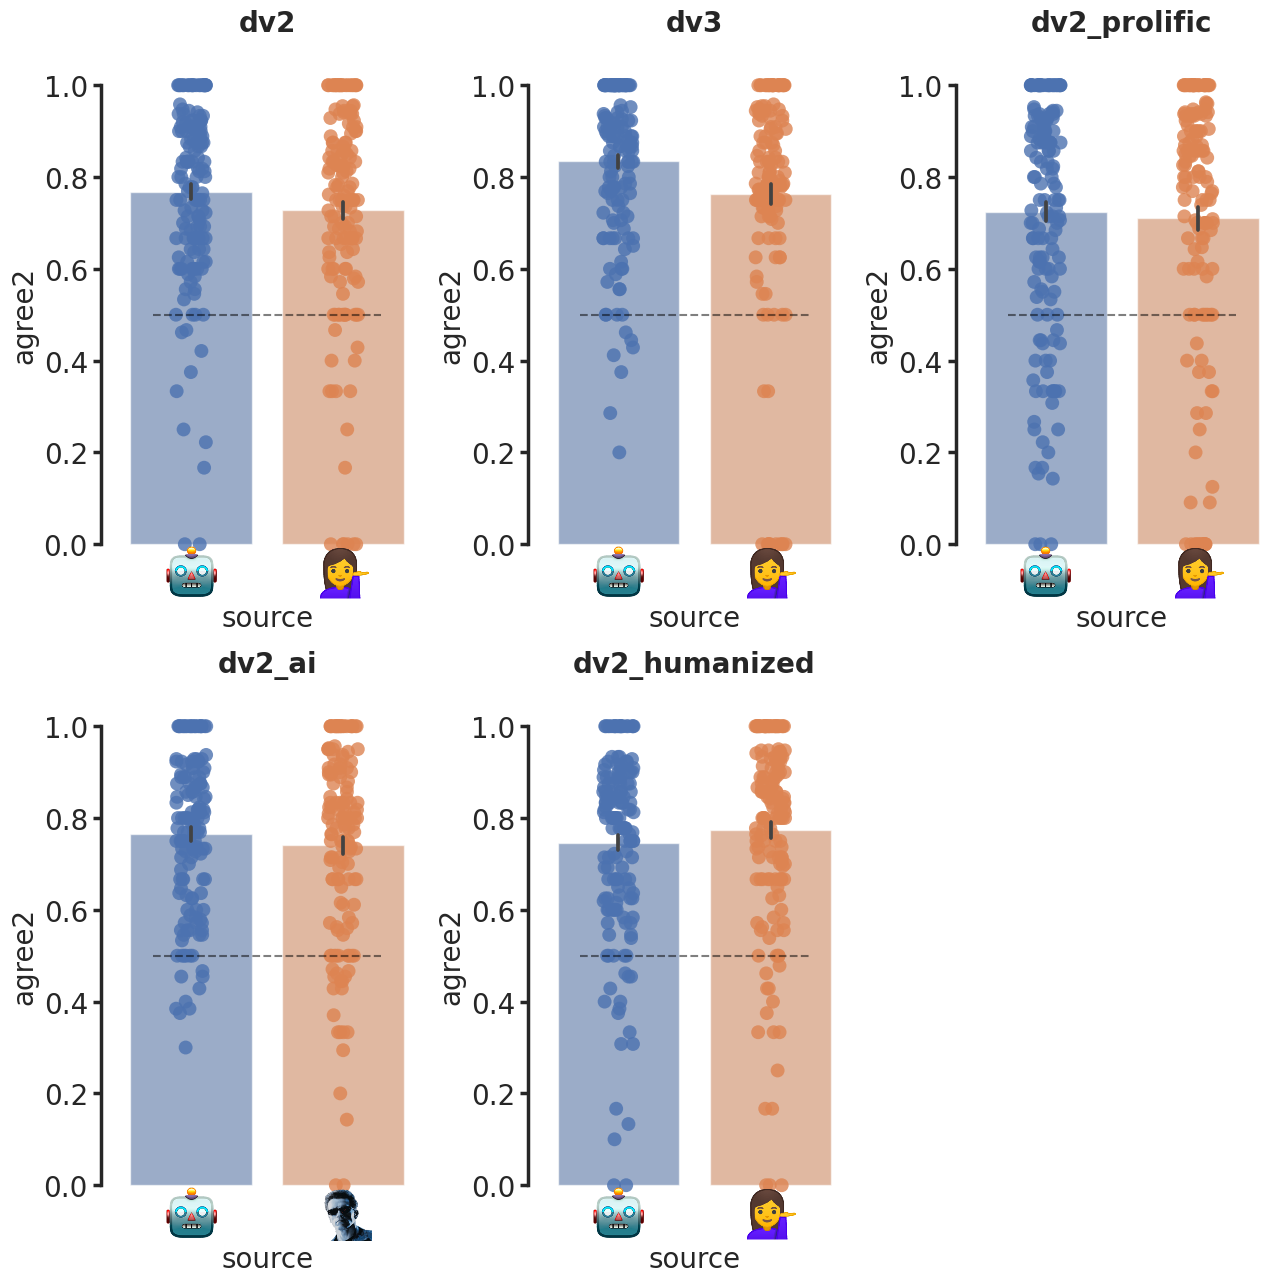

In [111]:
sns.set(
    rc={'figure.figsize':(13,13), "figure.dpi": 100, 'legend.fontsize': 20, 'axes.labelsize': 20, 'axes.titlesize': 20,
      'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")


count = 0
for engine in ['dv2', 'dv3', 'dv2_prolific', 'dv2_ai', 'dv2_humanized']:
    count += 1
    plt.subplot(2, 3, count)
#
# ids = np.random.choice(df[(df.engine==engine) & (df.q_id == 0) & (df.cond!='non_moral')].prolific_id.unique(), 22, replace=False)
    avg = df[(df.engine==engine) & (df.q_id == 2)].groupby(['prolific_id', 'source', 'correct'], as_index=False).mean()
    print(f'Size of {engine} dataset: ', avg.shape[0]/3)
    # print(avg.answer.unique())
    plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
    sns.barplot(x='source', y='agree2', data=avg, ci=68, alpha=0.6, zorder=0, dodge=True)
    sns.stripplot(x='source', y='agree2', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, zorder=1)
    plt.ylim(-.1, 1.1)
    plt.title('Agreement 1 (Yes/No)')
    plt.xticks(range(2), ('', ''))
    plt.xlabel('')
    plt.xticks([])
    for i, c in enumerate(avg.source.unique()):
        offset_image(i, c, plt.gca(), size=0.3)
    sns.despine(offset=10, trim=True, bottom=True);
    plt.gca().spines['left'].set_linewidth(2.5)
    plt.gca().spines['bottom'].set_linewidth(2.5)

    plt.xlabel('source')
    plt.title(engine, fontweight='bold')
    source = avg.source.unique()
    pg.ttest(avg[avg.source==source[0]].agree1, avg[avg.source==source[1]].agree1, paired=True)
plt.tight_layout()
# plt.legend([], [], frameon=False)
print('ANOVA: VAR=agree1, ENGINE=dv2')
#

<AxesSubplot:>

<AxesSubplot:xlabel='answer', ylabel='agree1'>

<AxesSubplot:xlabel='answer', ylabel='agree1'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f90c4bdca00>,
 [Text(0, 0, ''), Text(1, 0, '')])

([], [])

<AxesSubplot:>

<AxesSubplot:xlabel='answer', ylabel='agree2'>

<AxesSubplot:xlabel='answer', ylabel='agree2'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 2 (Justification)')

([<matplotlib.axis.XTick at 0x7f90c4b5ae20>,
 [Text(0, 0, ''), Text(1, 0, '')])

([], [])

Text(0.5, 0.98, 'dv2_ai')

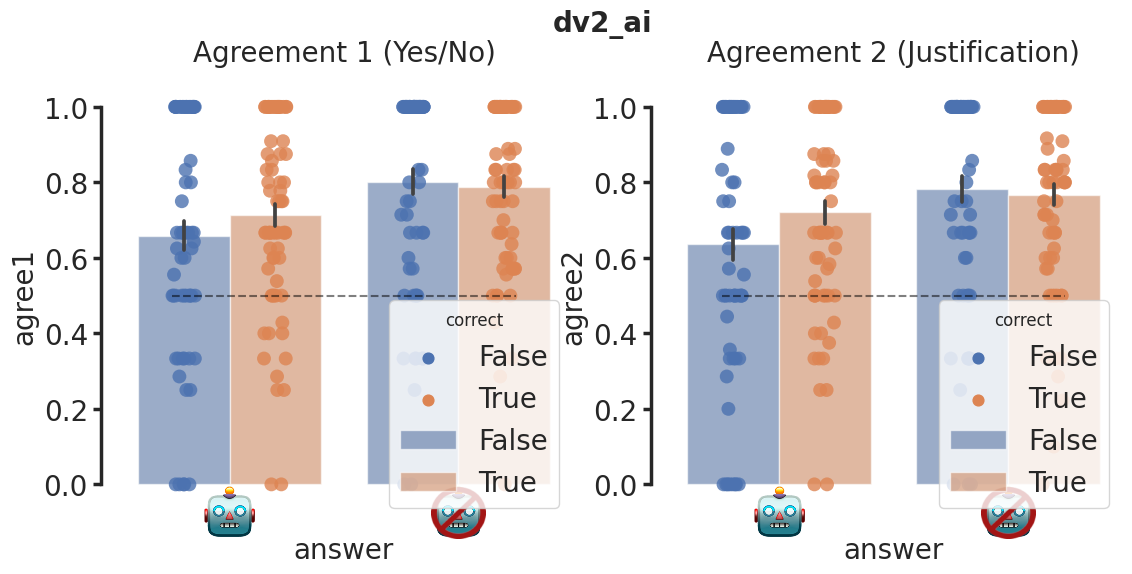

In [17]:
sns.set(
    rc={'figure.figsize':(13,6), "figure.dpi": 100, 'legend.fontsize': 20, 'axes.labelsize': 20, 'axes.titlesize': 20,
      'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})

# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and answer + anova
# -------------------------------------------------------------------------------


#plt.subplot(1, 3, 1)
#plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
## raincloud(x='answer', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
#sns.barplot(x='answer', y='correct', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0, dodge=True)
#sns.stripplot(x='answer', y='correct', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1)
#plt.ylim(-.1, 1.1)
#plt.title('Correct identification')
#plt.xticks(range(2), ('', ''))
#plt.xlabel('id choice')
#plt.xticks([])
#for i, c in enumerate(avg.answer.unique()):
#    offset_image(i, c, plt.gca(), size=0.3)
#sns.despine(offset=10, trim=True, bottom=True);
#plt.gca().spines['left'].set_linewidth(2.5)
#plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
# print(pg.mixed_anova(data=avg, dv='correct', within='answer', between='correct', subject='prolific_id'))



# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and answer + anova
# -------------------------------------------------------------------------------
engine = 'dv2_ai'
avg = df[(df.engine==engine) & (df.q_id==2) & (df.cond=='personal_moral')].groupby(['prolific_id', 'answer', 'correct'], as_index=False).mean()

plt.subplot(1, 2, 1)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='answer', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='answer', y='agree1', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0, dodge=True)
sns.stripplot(x='answer', y='agree1', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement 1 (Yes/No)')
plt.xticks(range(2), ('', ''))

# plt.xlabel('id choice')
plt.xticks([])
for i, c in enumerate(avg.answer.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
# print(pg.mixed_anova(data=avg, dv='agree1', within='answer', between='correct', subject='prolific_id'))


# -------------------------------------------------------------------------------
# Plot:  agreement 2 per correct and answer + anova
# -------------------------------------------------------------------------------
plt.subplot(1, 2, 2)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='answer', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='answer', y='agree2', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0)
sns.stripplot(x='answer', y='agree2', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1, edgecolor='white')
plt.ylim(-.1, 1.1)
plt.title('Agreement 2 (Justification)')
plt.xticks(range(2), ('', ''))
# plt.xlabel('')
plt.xticks([])

# plt.xlabel('id choice')
for i, c in enumerate(avg.answer.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.suptitle(engine, fontweight='bold', fontsize=20)
# plt.legend([], [], frameon=False)
# print(pg.rm_anova(data=avg, dv='agree2', within=['answer', 'correct'], subject='prolific_id', detailed=True))




In [ ]:
df.groupby(['prolific_id', 'source', 'correct'], as_index=False).size()


,prolific_id,source,correct,size
0,542460e3fdf99b691e6ac927,AI,True,51
1,542460e3fdf99b691e6ac927,Human,False,36
2,542460e3fdf99b691e6ac927,Human,True,48
3,5483702ffdf99b24c654b810,AI,False,45
4,5483702ffdf99b24c654b810,AI,True,21
...,...,...,...,...
659,63ea61d8106e3e2dc14c4cc7,Human,True,69
660,63ea627512244090788d46ec,AI,False,12
661,63ea627512244090788d46ec,AI,True,48
662,63ea627512244090788d46ec,Human,False,3


  Source        SS   DF        MS         F     p-unc       ng2       eps
0   cond  0.340806    2  0.170403  7.192593  0.000872  0.024048  0.970557
1  Error  8.055105  340  0.023691       NaN       NaN       NaN       NaN
  Source        SS   DF        MS          F         p-unc     p-GG-corr  \
0   cond  2.099979    2  1.049989  51.383346  3.174503e-20  2.747741e-18   
1  Error  6.947706  340  0.020434        NaN           NaN           NaN   

        ng2       eps sphericity   W-spher   p-spher  
0  0.148092  0.890238      False  0.876705  0.000015  
1       NaN       NaN        NaN       NaN       NaN  


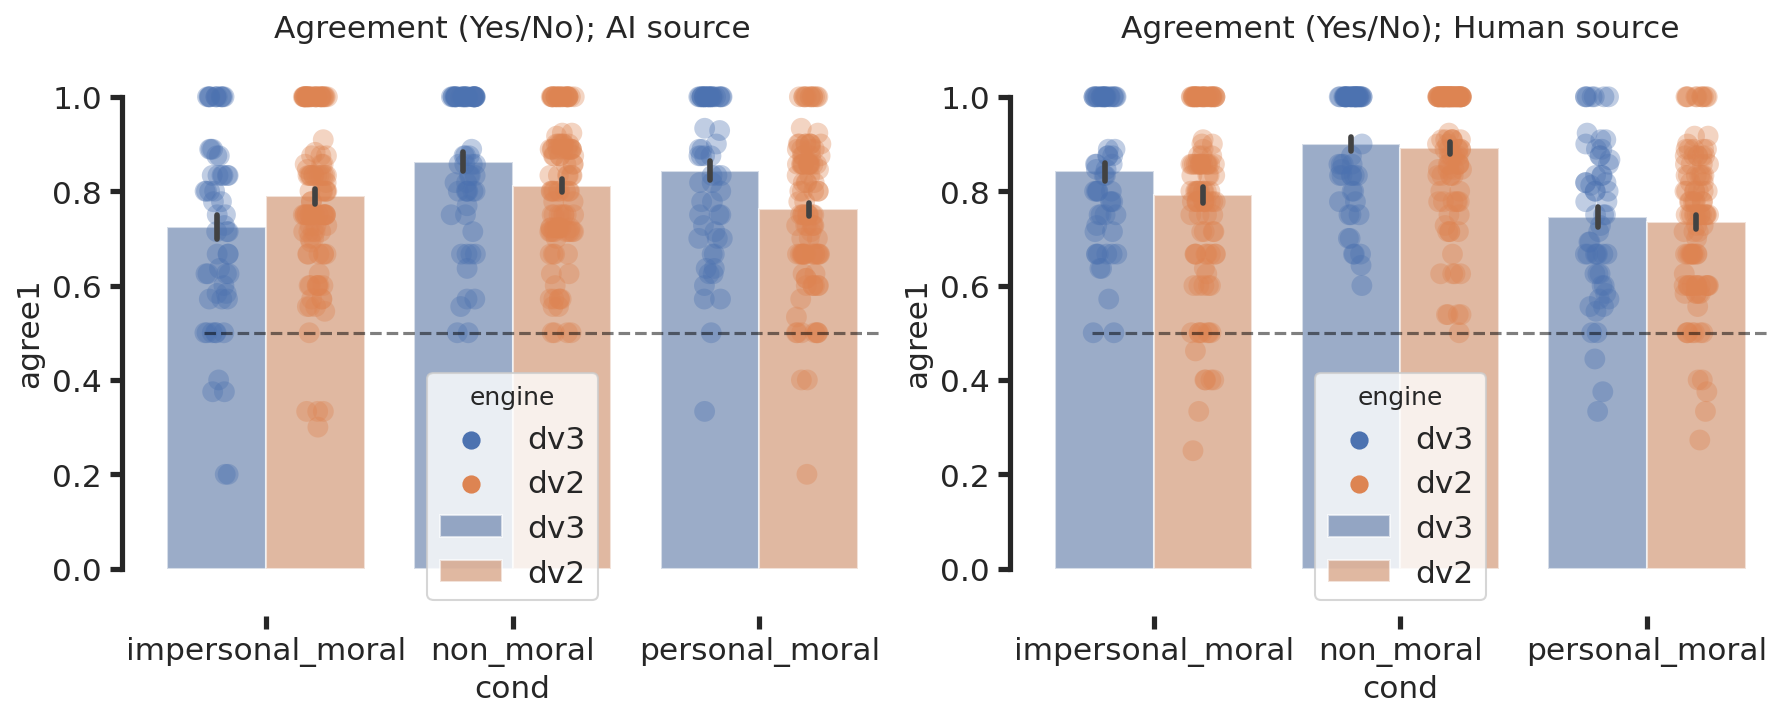

In [ ]:
sns.set(
    rc={'figure.figsize':(14,5), "figure.dpi": 150, 'legend.fontsize': 15, 'axes.labelsize': 15, 'axes.titlesize': 15,
      'xtick.labelsize': 15, 'ytick.labelsize': 15, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and source + anova
# -------------------------------------------------------------------------------

avg = df[df.source=='AI'].groupby(['prolific_id', 'cond', 'engine'], as_index=False).mean()
plt.subplot(1, 2, 1)
# avg = df.groupby(['prolific_id', 'cond', 'agree1'], as_index=False).mean()
plt.plot([-0.25, 3.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='cond', y='agree1', hue='engine',data=avg, ci=68, alpha=0.6)
sns.stripplot(x='cond', y='agree1', data=avg, hue='engine', alpha=0.35, jitter=0.1, size=10, dodge=True, zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement (Yes/No); AI source')
# plt.xticks(range(2), ('', ''))
# plt.xlabel('')
# plt.xticks([])
# for i, c in enumerate(avg.source.unique()):
    # offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
print(pg.rm_anova(data=avg, dv='agree1', within='cond', subject='prolific_id', detailed=True))


#plt.plot([-0.25, 3.25], [0.5, 0.5], '--', color='black', alpha=0.5)
## raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
#sns.barplot(x='cond', y='correct', data=avg, ci=68, alpha=0.6)
#sns.stripplot(x='cond', y='correct', data=avg, alpha=0.35, jitter=0.1, size=10, dodge=True, zorder=1)
#plt.ylim(-.1, 1.1)
#plt.title('Accuracy Turing')
#plt.xticks(range(2), ('', ''))
#plt.xlabel('')
#plt.xticks([])
## for i, c in enumerate(avg.source.unique()):
#    # offset_image(i, c, plt.gca(), size=0.3)
#sns.despine(offset=10, trim=True, bottom=True);
#plt.gca().spines['left'].set_linewidth(2.5)
#plt.gca().spines['bottom'].set_linewidth(2.5)
#plt.legend([], [], frameon=False)
#print(pg.rm_anova(data=avg, dv='correct', within='cond', subject='prolific_id', detailed=True))


# -------------------------------------------------------------------------------
# Plot:  agreement 2 per correct and source + anova
# -------------------------------------------------------------------------------
#
avg = df[df.source=='Human'].groupby(['prolific_id', 'cond', 'engine'], as_index=False).mean()
plt.subplot(1, 2, 2)
# avg = df.groupby(['prolific_id', 'cond', 'agree1'], as_index=False).mean()
plt.plot([-0.25, 3.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='cond', y='agree1', hue='engine',data=avg, ci=68, alpha=0.6)
sns.stripplot(x='cond', y='agree1', data=avg, hue='engine', alpha=0.35, jitter=0.1, size=10, dodge=True, zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement (Yes/No); Human source')
# plt.xticks(range(2), ('', ''))
# plt.xlabel('')
# plt.xticks([])
# for i, c in enumerate(avg.source.unique()):
    # offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
print(pg.rm_anova(data=avg, dv='agree1', within='cond', subject='prolific_id', detailed=True))
